In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('default')
import yfinance as yf
from datetime import datetime

In [2]:
# Define the ticker symbol
ticker_symbol = 'BBNI.JK'

# Fetch the data
bbni_data = yf.download(ticker_symbol, start='2019-03-11', end='2024-03-11')
bbni_data

[*********************100%%**********************]  1 of 1 completed


Open    High     Low   Close    Adj Close    Volume
Date                                                             
2019-03-11  4400.0  4400.0  4337.5  4337.5  3665.536377  14711800
2019-03-12  4325.0  4362.5  4300.0  4337.5  3665.536377  20181600
2019-03-13  4287.5  4337.5  4262.5  4300.0  3633.845947  32738800
2019-03-14  4362.5  4412.5  4337.5  4412.5  3728.917236  13382000
2019-03-15  4462.5  4562.5  4450.0  4537.5  3834.552246  34814400
...            ...     ...     ...     ...          ...       ...
2024-03-04  5900.0  5925.0  5800.0  5875.0  5607.047363  35600700
2024-03-05  5875.0  5950.0  5850.0  5900.0  5630.906738  49795500
2024-03-06  5900.0  5950.0  5875.0  5950.0  5678.626465  28923100
2024-03-07  5975.0  6025.0  5950.0  5975.0  5702.486328  47464200
2024-03-08  6000.0  6125.0  5975.0  6100.0  5821.785156  73185000

[1229 rows x 6 columns]

In [3]:
# drop 0 value in Volume
bbni_data = bbni_data[bbni_data.Volume != 0]

#Data telah bersih
a = bbni_data[bbni_data.Volume == 0]
len(a)

bbni_data

Open    High     Low   Close    Adj Close    Volume
Date                                                             
2019-03-11  4400.0  4400.0  4337.5  4337.5  3665.536377  14711800
2019-03-12  4325.0  4362.5  4300.0  4337.5  3665.536377  20181600
2019-03-13  4287.5  4337.5  4262.5  4300.0  3633.845947  32738800
2019-03-14  4362.5  4412.5  4337.5  4412.5  3728.917236  13382000
2019-03-15  4462.5  4562.5  4450.0  4537.5  3834.552246  34814400
...            ...     ...     ...     ...          ...       ...
2024-03-04  5900.0  5925.0  5800.0  5875.0  5607.047363  35600700
2024-03-05  5875.0  5950.0  5850.0  5900.0  5630.906738  49795500
2024-03-06  5900.0  5950.0  5875.0  5950.0  5678.626465  28923100
2024-03-07  5975.0  6025.0  5950.0  5975.0  5702.486328  47464200
2024-03-08  6000.0  6125.0  5975.0  6100.0  5821.785156  73185000

[1218 rows x 6 columns]

In [4]:
# Create a new dataframe with only the Close column 
data = bbni_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.90) # 90% 10%

# Split dataset into training and testing sets
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len:]

# Normalize data
# Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_train_data

array([[0.81824926],
       [0.81824926],
       [0.80712166],
       ...,
       [0.92210682],
       [0.93323442],
       [0.91097923]])

In [5]:
print(scaled_train_data.shape)
print(len(scaled_train_data))

(1097, 1)
1097


In [6]:
from keras.layers import Activation
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
# Function to train LSTM model and return predictions and RMSE
def train_lstm_model(x_train, y_train, x_test, actual):
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1), activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout with a rate of 0.2
    model.add(LSTM(50, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.2))  # Adding dropout with a rate of 0.2
    model.add(Dense(25, activation='linear'))  # Adding a linear activation function
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, actual),
              callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, verbose=1, mode='min')], verbose= 1, shuffle=False)

    # Get the models predicted price values from train
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions) # unscaling the values

    # Get the root mean squared error (RMSE)
    rmse= np.sqrt(np.mean(((predictions - actual)**2)))
    mape= np.mean(np.abs((actual - predictions) / actual)) * 100
    
    return predictions, rmse, mape

In [7]:
# Create empty lists to store results
all_predictions = []
all_rmse = []
all_mape = []

# Perform 50 runs of LSTM
for i in range(50):
    print(f"Run: {i+1}")
    # Create the scaled training data set with window size = 100
    train_data = scaled_train_data
    #split the data into x_train and y_train dataset
    x_train = []
    y_train = []
    for i in range(100, len(train_data)):
        x_train.append(train_data[i-100:i])
        y_train.append(train_data[i])
    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    print(len(x_train))
    print(len(y_train))
    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create the scaled testing data set
    testing_data = dataset[training_data_len-100:]
    test_data = scaler.transform(testing_data.reshape(-1,1))
    # Create the dataset x_test and y_test
    x_test = []
    for i in range(100, len(test_data)):
        x_test.append(test_data[i-100:i])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    actual = dataset[training_data_len:]
    # Train LSTM model and return predictions, RMSE, and MAPE
    predictions, rmse, mape = train_lstm_model(x_train, y_train, x_test, actual)
    
    # Append predictions and RMSE to lists
    all_predictions.append(predictions)
    all_rmse.append(rmse)
    all_mape.append(mape)

Run: 1
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1587 - val_loss: 28787848.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0118 - val_loss: 28787506.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0126 - val_loss: 28787164.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0148 - val_loss: 28785846.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0268 - val_loss: 28784772.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0493 - val_loss: 28784996.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0484 - val_loss: 28785648.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0522 - val_loss: 28786258.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0367 - val_loss: 28785976.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0159 - val_loss: 28785712.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Run: 2
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0953 - val_loss: 28786676.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0087 - val_loss: 28786468.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0107 - val_loss: 28786678.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0120 - val_loss: 28785876.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0209 - val_loss: 28784986.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0306 - val_loss: 28785392.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0315 - val_loss: 28785052.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0425 - val_loss: 28785580.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0450 - val_loss: 28785744.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0267 - val_loss: 28785542.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Run: 3
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0854 - val_loss: 28787232.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0088 - val_loss: 28786760.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0103 - val_loss: 28786878.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0105 - val_loss: 28786840.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0128 - val_loss: 28785876.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0250 - val_loss: 28784592.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0469 - val_loss: 28785204.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0377 - val_loss: 28785528.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0523 - val_loss: 28786408.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0372 - val_loss: 28785938.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0183 - val_loss: 28785692.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1232 - val_loss: 28787032.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0084 - val_loss: 28786606.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0100 - val_loss: 28786948.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0106 - val_loss: 28786318.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0157 - val_loss: 28785424.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0266 - val_loss: 28785304.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0288 - val_loss: 28784876.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0455 - val_loss: 28785306.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0479 - val_loss: 28785410.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0353 - val_loss: 28785560.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0196 - val_loss: 28785400.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1163 - val_loss: 28786926.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0101 - val_loss: 28786980.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0115 - val_loss: 28786518.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0144 - val_loss: 28785056.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0307 - val_loss: 28785064.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0337 - val_loss: 28784904.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0372 - val_loss: 28785300.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0494 - val_loss: 28785548.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0358 - val_loss: 28785628.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0175 - val_loss: 28785496.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0068 - val_loss: 28785798.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1298 - val_loss: 28786396.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0098 - val_loss: 28786248.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0144 - val_loss: 28785610.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0235 - val_loss: 28785032.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0322 - val_loss: 28785316.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0364 - val_loss: 28785172.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0449 - val_loss: 28785548.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0465 - val_loss: 28785978.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0269 - val_loss: 28785626.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 7
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1386 - val_loss: 28786776.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0090 - val_loss: 28786792.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0112 - val_loss: 28787024.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0117 - val_loss: 28786384.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0195 - val_loss: 28785352.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0300 - val_loss: 28785292.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0345 - val_loss: 28785104.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0471 - val_loss: 28785692.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0493 - val_loss: 28786062.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0337 - val_loss: 28785796.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0154 - val_loss: 28785740.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1352 - val_loss: 28786638.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0131 - val_loss: 28787024.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0135 - val_loss: 28785572.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0292 - val_loss: 28784596.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0528 - val_loss: 28785068.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0513 - val_loss: 28785564.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0417 - val_loss: 28785900.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0313 - val_loss: 28785850.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0153 - val_loss: 28785640.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 9
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1010 - val_loss: 28786944.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0098 - val_loss: 28787308.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0096 - val_loss: 28787424.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0107 - val_loss: 28786568.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0165 - val_loss: 28785508.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0305 - val_loss: 28785598.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0321 - val_loss: 28785108.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0517 - val_loss: 28785404.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0420 - val_loss: 28786116.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0376 - val_loss: 28786124.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0193 - val_loss: 28785764.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1159 - val_loss: 28786224.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0093 - val_loss: 28786456.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0119 - val_loss: 28786036.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0177 - val_loss: 28785056.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0339 - val_loss: 28784792.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0435 - val_loss: 28785002.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0384 - val_loss: 28785406.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0342 - val_loss: 28785508.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0233 - val_loss: 28785500.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0129 - val_loss: 28785692.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 11
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1543 - val_loss: 28786952.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0101 - val_loss: 28787292.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0121 - val_loss: 28786960.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0173 - val_loss: 28785382.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0375 - val_loss: 28784846.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0591 - val_loss: 28785194.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0533 - val_loss: 28785928.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0455 - val_loss: 28786148.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0243 - val_loss: 28785640.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0113 - val_loss: 28785928.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 12
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0704 - val_loss: 28787532.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0088 - val_loss: 28786872.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0100 - val_loss: 28787472.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0095 - val_loss: 28787050.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0115 - val_loss: 28786886.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0155 - val_loss: 28786174.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0235 - val_loss: 28785896.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0328 - val_loss: 28785336.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0511 - val_loss: 28786240.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0567 - val_loss: 28786384.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0410 - val_loss: 28786284.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1041 - val_loss: 28786664.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0104 - val_loss: 28786796.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0110 - val_loss: 28786430.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0153 - val_loss: 28785160.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0326 - val_loss: 28784748.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0428 - val_loss: 28784924.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0410 - val_loss: 28785456.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0451 - val_loss: 28785776.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0301 - val_loss: 28785568.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0178 - val_loss: 28785520.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 14
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1735 - val_loss: 28786732.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0109 - val_loss: 28787198.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0102 - val_loss: 28787172.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0109 - val_loss: 28786840.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0148 - val_loss: 28785368.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0314 - val_loss: 28784704.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0441 - val_loss: 28785020.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0430 - val_loss: 28785486.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0428 - val_loss: 28785888.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0328 - val_loss: 28785940.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0139 - val_loss: 28785700.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1611 - val_loss: 28787012.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0107 - val_loss: 28786936.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0131 - val_loss: 28786332.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0181 - val_loss: 28784964.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0344 - val_loss: 28784874.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0403 - val_loss: 28785354.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0477 - val_loss: 28785436.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0360 - val_loss: 28785532.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0241 - val_loss: 28785424.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0115 - val_loss: 28785416.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Run: 16
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1226 - val_loss: 28786600.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0100 - val_loss: 28786878.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0117 - val_loss: 28785824.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0224 - val_loss: 28785148.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0339 - val_loss: 28785900.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0296 - val_loss: 28785336.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0498 - val_loss: 28785726.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0453 - val_loss: 28785920.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0282 - val_loss: 28785584.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 17
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0550 - val_loss: 28787610.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0083 - val_loss: 28786858.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0069 - val_loss: 28786764.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0075 - val_loss: 28786976.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0078 - val_loss: 28787188.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0072 - val_loss: 28787300.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0075 - val_loss: 28787260.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0075 - val_loss: 28787234.0000
Epoch 8: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 18
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1615 - val_loss: 28787096.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0100 - val_loss: 28787024.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0122 - val_loss: 28786308.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0169 - val_loss: 28784978.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0324 - val_loss: 28784924.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0457 - val_loss: 28785172.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0409 - val_loss: 28785424.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0423 - val_loss: 28785716.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0263 - val_loss: 28785556.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0103 - val_loss: 28785676.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 19
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1083 - val_loss: 28787068.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0093 - val_loss: 28786964.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0104 - val_loss: 28786608.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0141 - val_loss: 28785882.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0232 - val_loss: 28785166.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0326 - val_loss: 28785778.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0366 - val_loss: 28785330.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0535 - val_loss: 28786084.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0457 - val_loss: 28786030.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0271 - val_loss: 28785656.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 20
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0881 - val_loss: 28786696.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0078 - val_loss: 28786918.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0084 - val_loss: 28787374.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0087 - val_loss: 28786894.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0110 - val_loss: 28786776.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0145 - val_loss: 28785524.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0288 - val_loss: 28785272.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0347 - val_loss: 28785724.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0409 - val_loss: 28785618.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0524 - val_loss: 28785748.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0392 - val_loss: 28785916.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1070 - val_loss: 28787174.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0084 - val_loss: 28786632.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0118 - val_loss: 28786408.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0152 - val_loss: 28785056.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0314 - val_loss: 28784888.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0365 - val_loss: 28785216.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0352 - val_loss: 28785298.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0535 - val_loss: 28785712.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0379 - val_loss: 28785412.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0190 - val_loss: 28785424.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 22
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1724 - val_loss: 28785976.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0111 - val_loss: 28786828.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0116 - val_loss: 28785600.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0219 - val_loss: 28784762.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0350 - val_loss: 28785232.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0373 - val_loss: 28784980.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0394 - val_loss: 28785780.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0366 - val_loss: 28785652.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0207 - val_loss: 28785356.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 23
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1261 - val_loss: 28786956.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0097 - val_loss: 28786968.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0117 - val_loss: 28786648.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0137 - val_loss: 28785664.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0257 - val_loss: 28784888.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0435 - val_loss: 28785344.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0372 - val_loss: 28785488.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0486 - val_loss: 28786016.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0326 - val_loss: 28785796.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0169 - val_loss: 28785708.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 24
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1402 - val_loss: 28787460.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0098 - val_loss: 28786300.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0147 - val_loss: 28786100.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0176 - val_loss: 28785124.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0294 - val_loss: 28784900.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0387 - val_loss: 28784938.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0474 - val_loss: 28785122.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0460 - val_loss: 28785528.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0338 - val_loss: 28785394.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0186 - val_loss: 28785364.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 25
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0952 - val_loss: 28787456.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0081 - val_loss: 28786810.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0110 - val_loss: 28786644.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0137 - val_loss: 28785636.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0251 - val_loss: 28784842.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0429 - val_loss: 28784834.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0459 - val_loss: 28785082.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0446 - val_loss: 28785576.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0377 - val_loss: 28785700.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0192 - val_loss: 28785580.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0100 - val_loss: 28785818.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1268 - val_loss: 28786524.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0095 - val_loss: 28786796.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0105 - val_loss: 28785864.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0170 - val_loss: 28785168.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0259 - val_loss: 28784848.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0347 - val_loss: 28784962.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0387 - val_loss: 28785368.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0403 - val_loss: 28785364.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0284 - val_loss: 28785412.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0170 - val_loss: 28785404.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 27
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1940 - val_loss: 28786824.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0150 - val_loss: 28787564.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0154 - val_loss: 28785984.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0231 - val_loss: 28784828.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0433 - val_loss: 28785084.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0532 - val_loss: 28785156.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0432 - val_loss: 28785912.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0310 - val_loss: 28785546.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0149 - val_loss: 28785560.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 28
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1847 - val_loss: 28786492.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0118 - val_loss: 28786604.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0151 - val_loss: 28785734.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0239 - val_loss: 28784818.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0414 - val_loss: 28785068.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0438 - val_loss: 28785198.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0396 - val_loss: 28785700.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0339 - val_loss: 28785698.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0200 - val_loss: 28785770.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 29
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1364 - val_loss: 28786026.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0086 - val_loss: 28786650.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0099 - val_loss: 28786434.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0127 - val_loss: 28785474.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0224 - val_loss: 28784824.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0333 - val_loss: 28784784.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0393 - val_loss: 28785228.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0401 - val_loss: 28785398.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0393 - val_loss: 28785776.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0276 - val_loss: 28785604.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0117 - val_loss: 28785900.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1170 - val_loss: 28787254.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0089 - val_loss: 28786744.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0107 - val_loss: 28786908.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0122 - val_loss: 28785936.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0223 - val_loss: 28785386.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0285 - val_loss: 28784940.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0407 - val_loss: 28784978.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0482 - val_loss: 28785450.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0447 - val_loss: 28786204.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0264 - val_loss: 28785536.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0116 - val_loss: 28785762.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1974 - val_loss: 28786932.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0081 - val_loss: 28786902.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0105 - val_loss: 28786632.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0130 - val_loss: 28786048.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0190 - val_loss: 28784780.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0411 - val_loss: 28784772.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0502 - val_loss: 28784992.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0381 - val_loss: 28785504.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0361 - val_loss: 28785552.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0185 - val_loss: 28785448.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0091 - val_loss: 28785906.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1130 - val_loss: 28786814.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0102 - val_loss: 28786572.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0136 - val_loss: 28785810.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0219 - val_loss: 28785120.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0336 - val_loss: 28785000.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0408 - val_loss: 28785324.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0496 - val_loss: 28785670.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0390 - val_loss: 28785630.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0197 - val_loss: 28785446.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0097 - val_loss: 28785566.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 33
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0955 - val_loss: 28787364.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0092 - val_loss: 28786918.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0078 - val_loss: 28786902.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0085 - val_loss: 28787124.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0084 - val_loss: 28787154.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0084 - val_loss: 28786864.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0106 - val_loss: 28786070.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0187 - val_loss: 28785592.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0279 - val_loss: 28784988.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0453 - val_loss: 28785716.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0553 - val_loss: 28785708.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1733 - val_loss: 28785936.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0109 - val_loss: 28786312.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0129 - val_loss: 28785304.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0224 - val_loss: 28784508.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0378 - val_loss: 28784684.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0374 - val_loss: 28784988.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0316 - val_loss: 28785110.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0275 - val_loss: 28785214.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0178 - val_loss: 28785192.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 35
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1274 - val_loss: 28787088.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0088 - val_loss: 28787352.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0098 - val_loss: 28787112.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0118 - val_loss: 28786248.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0176 - val_loss: 28785074.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0321 - val_loss: 28784940.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0378 - val_loss: 28784916.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0433 - val_loss: 28785688.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0421 - val_loss: 28785866.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0264 - val_loss: 28785466.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0125 - val_loss: 28785654.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1702 - val_loss: 28787134.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0124 - val_loss: 28787892.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0117 - val_loss: 28786904.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0131 - val_loss: 28786460.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0192 - val_loss: 28785548.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0294 - val_loss: 28785518.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0382 - val_loss: 28785468.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0570 - val_loss: 28786512.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0414 - val_loss: 28785974.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0199 - val_loss: 28785736.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0085 - val_loss: 28785936.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1927 - val_loss: 28786408.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0141 - val_loss: 28786492.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0169 - val_loss: 28785188.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0320 - val_loss: 28784668.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0533 - val_loss: 28785058.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0415 - val_loss: 28785392.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0356 - val_loss: 28785418.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0245 - val_loss: 28785388.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0127 - val_loss: 28785528.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 38
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1109 - val_loss: 28786804.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0083 - val_loss: 28786800.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0092 - val_loss: 28786828.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0107 - val_loss: 28786024.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0186 - val_loss: 28785132.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0299 - val_loss: 28784640.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0417 - val_loss: 28785260.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0341 - val_loss: 28785514.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0467 - val_loss: 28785552.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0351 - val_loss: 28785644.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0225 - val_loss: 28785592.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1113 - val_loss: 28786504.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0091 - val_loss: 28786904.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0109 - val_loss: 28786878.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0143 - val_loss: 28785584.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0290 - val_loss: 28785616.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0272 - val_loss: 28785596.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0363 - val_loss: 28785084.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0521 - val_loss: 28785738.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0436 - val_loss: 28786196.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0263 - val_loss: 28785840.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0107 - val_loss: 28785828.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1293 - val_loss: 28787204.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0086 - val_loss: 28787020.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0107 - val_loss: 28786994.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0134 - val_loss: 28785848.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0240 - val_loss: 28784928.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0405 - val_loss: 28784932.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0445 - val_loss: 28785244.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0525 - val_loss: 28785944.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0401 - val_loss: 28785718.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0237 - val_loss: 28785662.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 41
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0923 - val_loss: 28786760.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0086 - val_loss: 28787166.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0083 - val_loss: 28787066.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0114 - val_loss: 28786572.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0166 - val_loss: 28785534.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0292 - val_loss: 28784852.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0443 - val_loss: 28786116.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0310 - val_loss: 28785948.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0530 - val_loss: 28786212.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0344 - val_loss: 28785970.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0123 - val_loss: 28785692.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1207 - val_loss: 28786820.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0090 - val_loss: 28786748.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0118 - val_loss: 28786492.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0138 - val_loss: 28785504.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0256 - val_loss: 28784568.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0472 - val_loss: 28785044.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0404 - val_loss: 28785140.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0478 - val_loss: 28785592.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0359 - val_loss: 28785660.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0200 - val_loss: 28785664.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 43
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1316 - val_loss: 28787328.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0088 - val_loss: 28787012.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0100 - val_loss: 28787288.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0115 - val_loss: 28786488.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0167 - val_loss: 28785776.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0268 - val_loss: 28785422.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0361 - val_loss: 28785644.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0408 - val_loss: 28785688.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0554 - val_loss: 28786440.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0392 - val_loss: 28786016.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0155 - val_loss: 28785736.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1254 - val_loss: 28786980.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0092 - val_loss: 28787004.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0121 - val_loss: 28786352.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0201 - val_loss: 28785014.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0389 - val_loss: 28784852.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0434 - val_loss: 28784946.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0551 - val_loss: 28785818.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0502 - val_loss: 28786128.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0353 - val_loss: 28785882.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0160 - val_loss: 28785756.0000
Epoch 10: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Run: 45
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1359 - val_loss: 28786692.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0098 - val_loss: 28786812.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0123 - val_loss: 28786144.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0196 - val_loss: 28785380.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0280 - val_loss: 28785308.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0331 - val_loss: 28785004.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0500 - val_loss: 28785950.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0470 - val_loss: 28785830.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0317 - val_loss: 28785354.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0160 - val_loss: 28785456.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0082 - val_loss: 28785806.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1119 - val_loss: 28787620.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0098 - val_loss: 28787064.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0098 - val_loss: 28787196.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0096 - val_loss: 28786944.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0140 - val_loss: 28786090.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0209 - val_loss: 28785456.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0286 - val_loss: 28785688.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0369 - val_loss: 28785388.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0604 - val_loss: 28786292.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0460 - val_loss: 28786064.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0236 - val_loss: 28785742.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1030 - val_loss: 28786212.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0105 - val_loss: 28786534.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0121 - val_loss: 28785738.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0197 - val_loss: 28784852.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0342 - val_loss: 28784912.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0318 - val_loss: 28785142.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0392 - val_loss: 28785496.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0433 - val_loss: 28785558.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0323 - val_loss: 28785544.0000
Epoch 9: early stopping
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Run: 48
997
997
Epoch 1/50


/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1235 - val_loss: 28786800.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0082 - val_loss: 28787100.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0097 - val_loss: 28787132.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0108 - val_loss: 28786692.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0152 - val_loss: 28785720.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0246 - val_loss: 28785732.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0309 - val_loss: 28784848.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0500 - val_loss: 28784992.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0514 - val_loss: 28786160.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0370 - val_loss: 28785808.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0175 - val_loss: 28785658.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1746 - val_loss: 28786990.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0087 - val_loss: 28786946.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0101 - val_loss: 28786936.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0099 - val_loss: 28786872.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0120 - val_loss: 28785960.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0178 - val_loss: 28784922.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0322 - val_loss: 28784922.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0366 - val_loss: 28785036.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0415 - val_loss: 28785452.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0395 - val_loss: 28785378.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0248 - val_loss: 28785528.00

/Users/shannenwibisono/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1469 - val_loss: 28787036.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0085 - val_loss: 28787336.0000
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0097 - val_loss: 28786772.0000
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0110 - val_loss: 28786704.0000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0136 - val_loss: 28785844.0000
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0222 - val_loss: 28785006.0000
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0357 - val_loss: 28785104.0000
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0485 - val_loss: 28785520.0000
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0492 - val_loss: 28785802.0000
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0334 - val_loss: 28785582.0000
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0180 - val_loss: 28785664.00

In [8]:
# Create DataFrame to store results
results_df = pd.DataFrame()

# Add predictions to DataFrame
for i in range(50):
    col_name = f'Prediction_{i+1}'
    predictions_series = pd.Series(all_predictions[i].reshape(-1), name=col_name)
    results_df = pd.concat([results_df, predictions_series], axis=1)

# Add RMSE & MAPE as a row to DataFrame if the lengths match
results_df.loc['RMSE'] = all_rmse
results_df.loc['MAPE'] = all_mape

# Calculate average of predictions from Prediction_1 to Prediction_50
results_df['Average_Prediction'] = results_df.iloc[:, :].mean(axis=1)

# Calculate standard deviation of predictions from Prediction_1 to Prediction_50
results_df['Prediction_Std'] = results_df.iloc[:, :-1].std(axis=1)

# Print results DataFrame
print(results_df)

      Prediction_1  Prediction_2  Prediction_3  Prediction_4  Prediction_5  \
0      4842.900391   4897.723145   4846.456543   4773.911621   4781.823730   
1      4845.245117   4895.733887   4846.562988   4771.908203   4779.528809   
2      4848.604492   4896.830566   4848.621094   4772.436035   4780.055176   
3      4852.812012   4900.124023   4852.191406   4775.198730   4782.895996   
4      4853.791504   4899.029785   4851.997559   4773.752930   4781.402344   
...            ...           ...           ...           ...           ...   
118    5704.901855   5756.499512   5711.024902   5743.976074   5716.136719   
119    5703.575684   5754.508789   5709.532227   5740.984375   5713.230957   
120    5704.412109   5756.207520   5710.887207   5742.215820   5714.454590   
RMSE    183.007654    160.388246    174.822302    164.844333    174.184982   
MAPE      2.771661      2.471794      2.641336      2.461659      2.582540   

      Prediction_6  Prediction_7  Prediction_8  Prediction_9  P

In [12]:
# Save DataFrame to CSV with header
results_df.to_csv('BBNILSTMFullW100.csv', header=True)

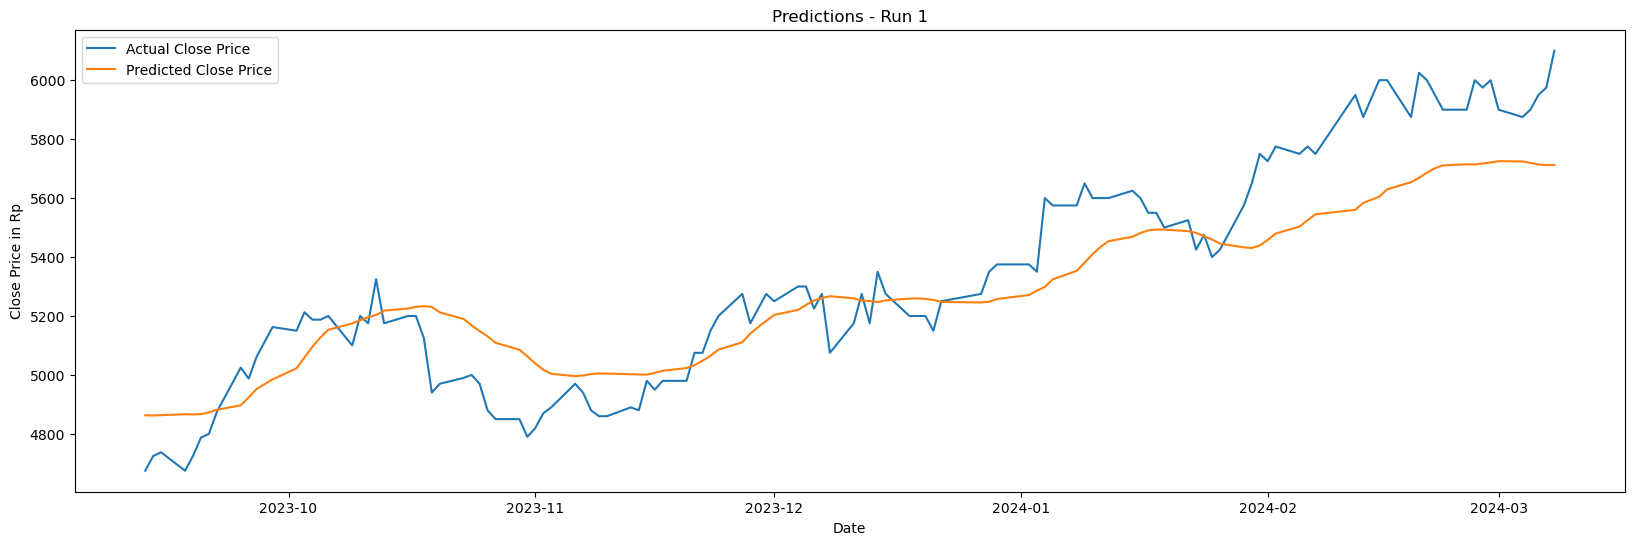

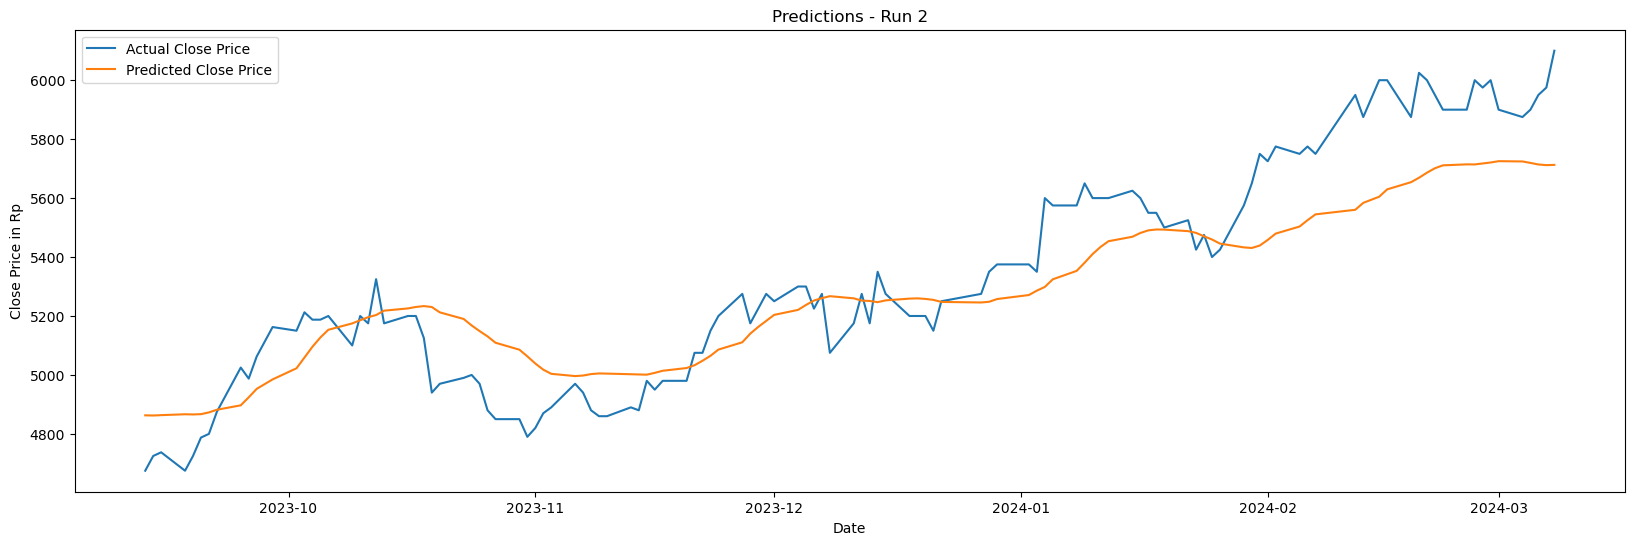

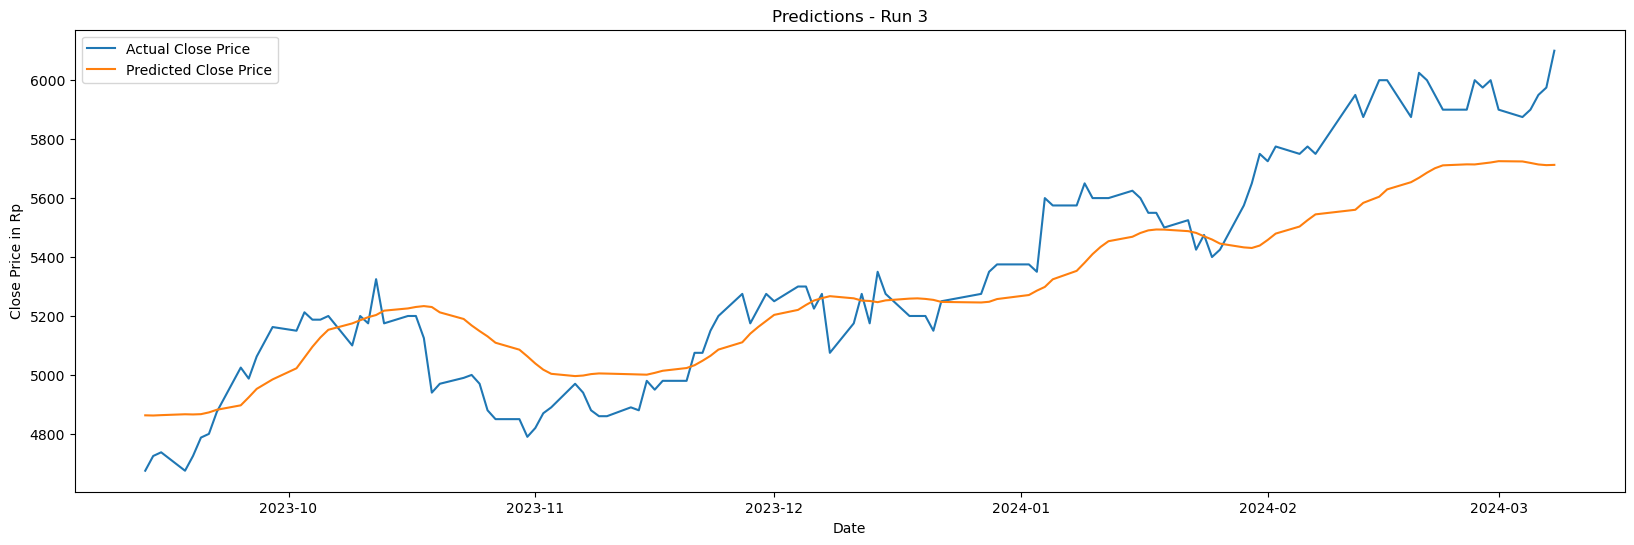

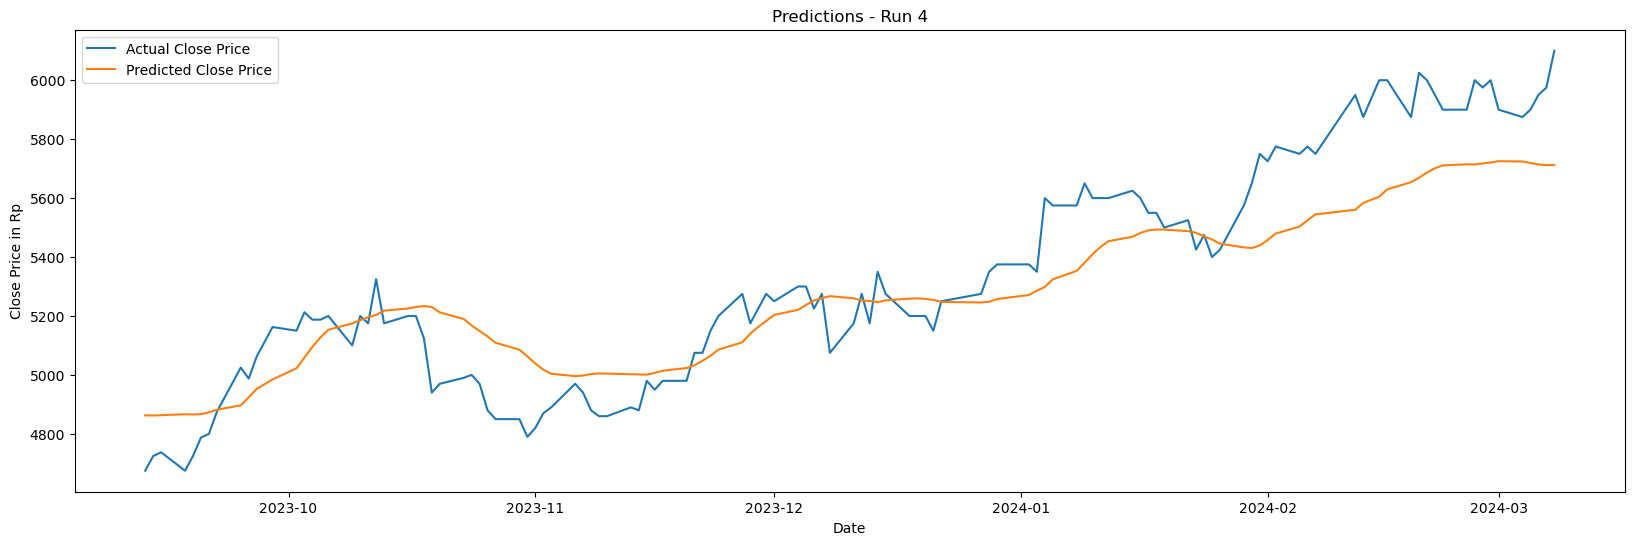

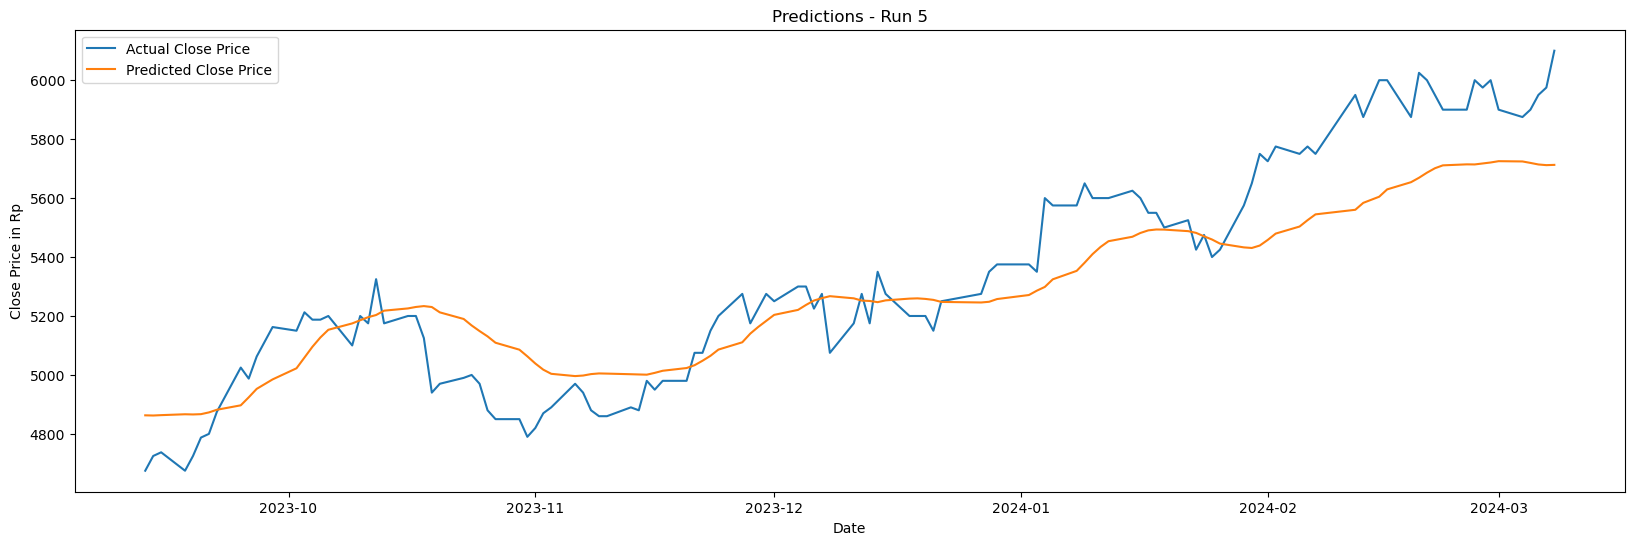

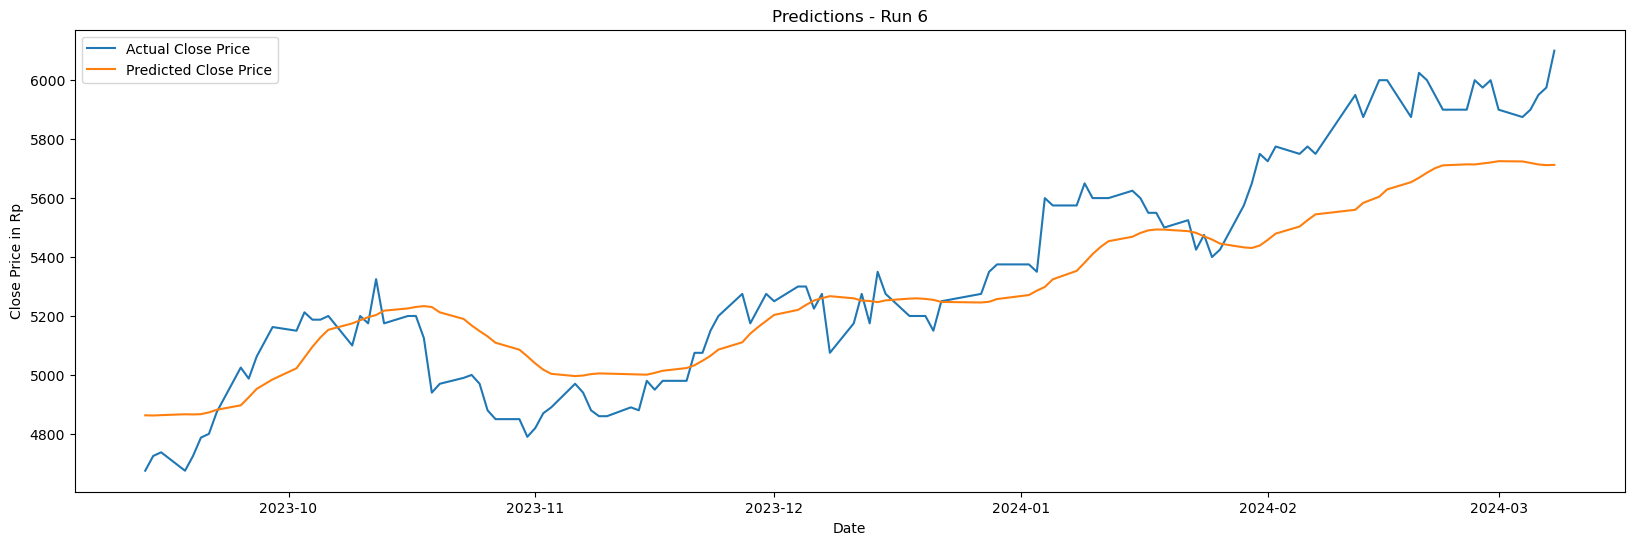

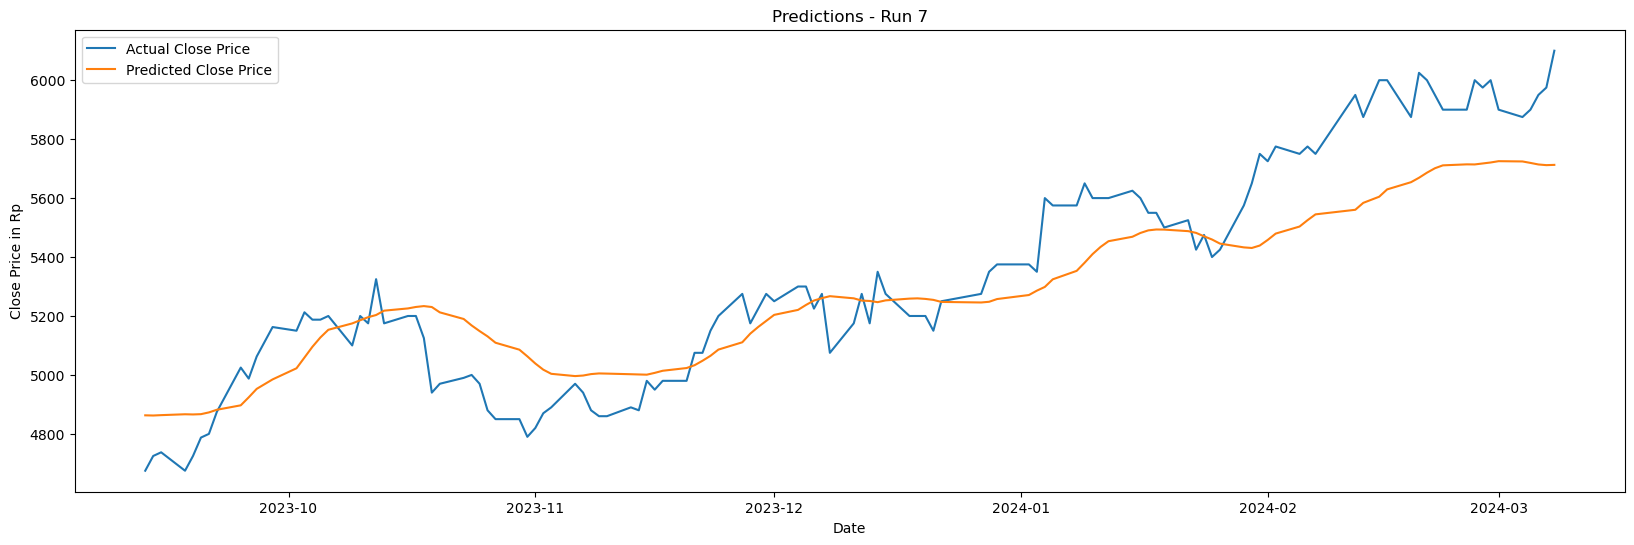

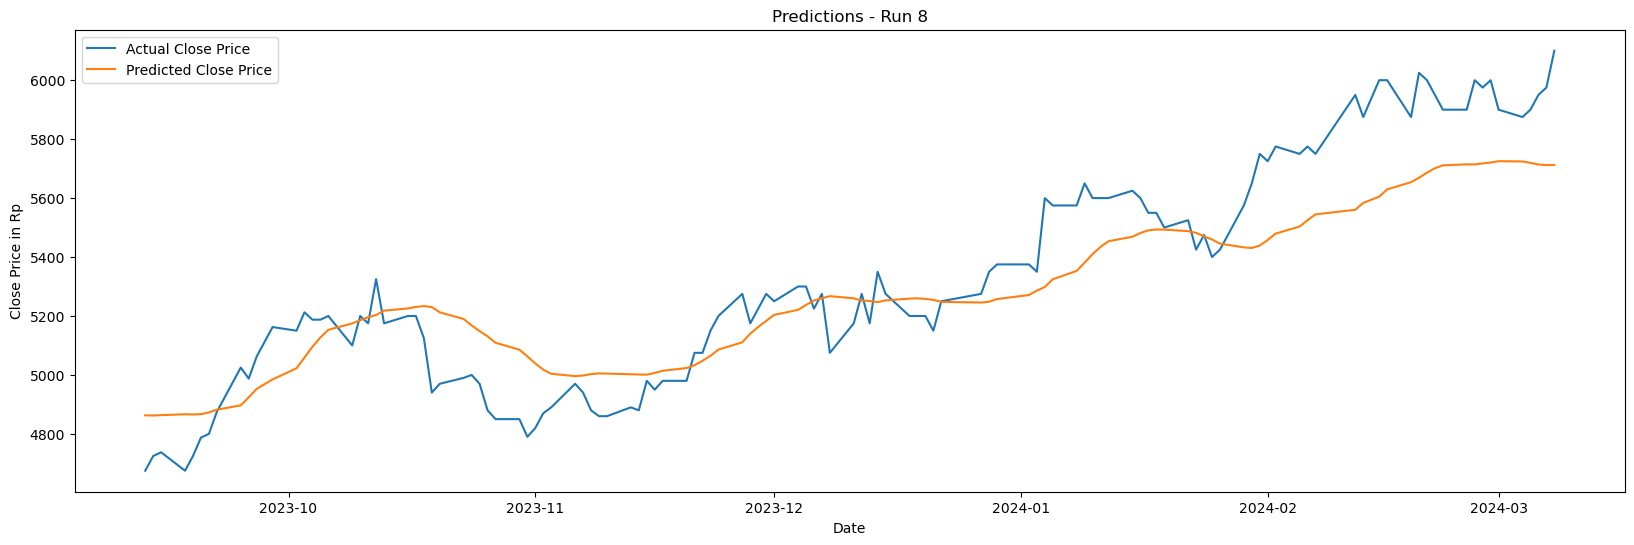

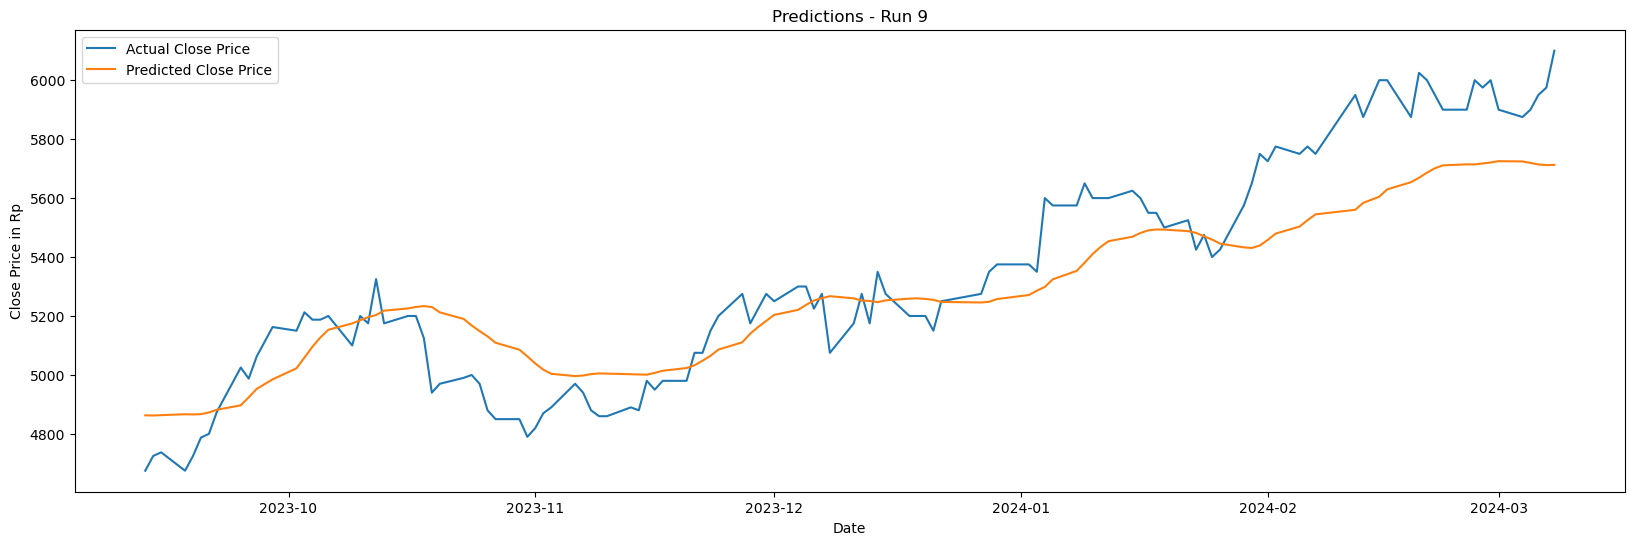

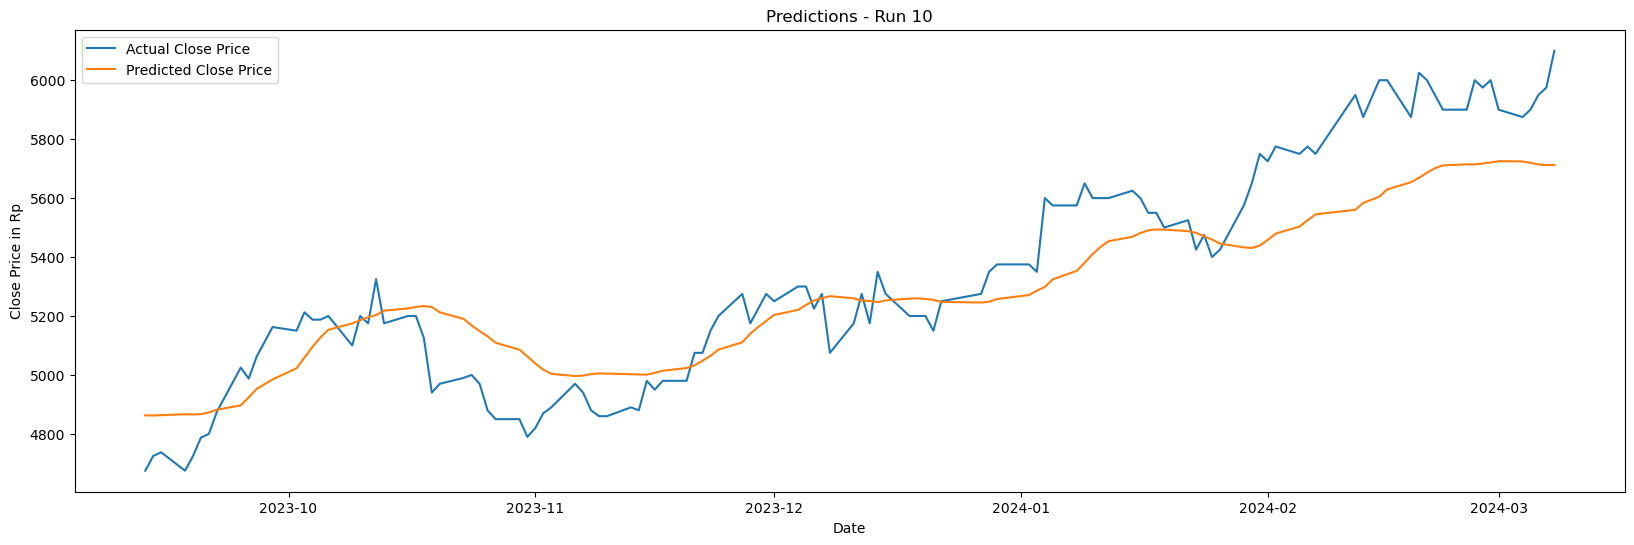

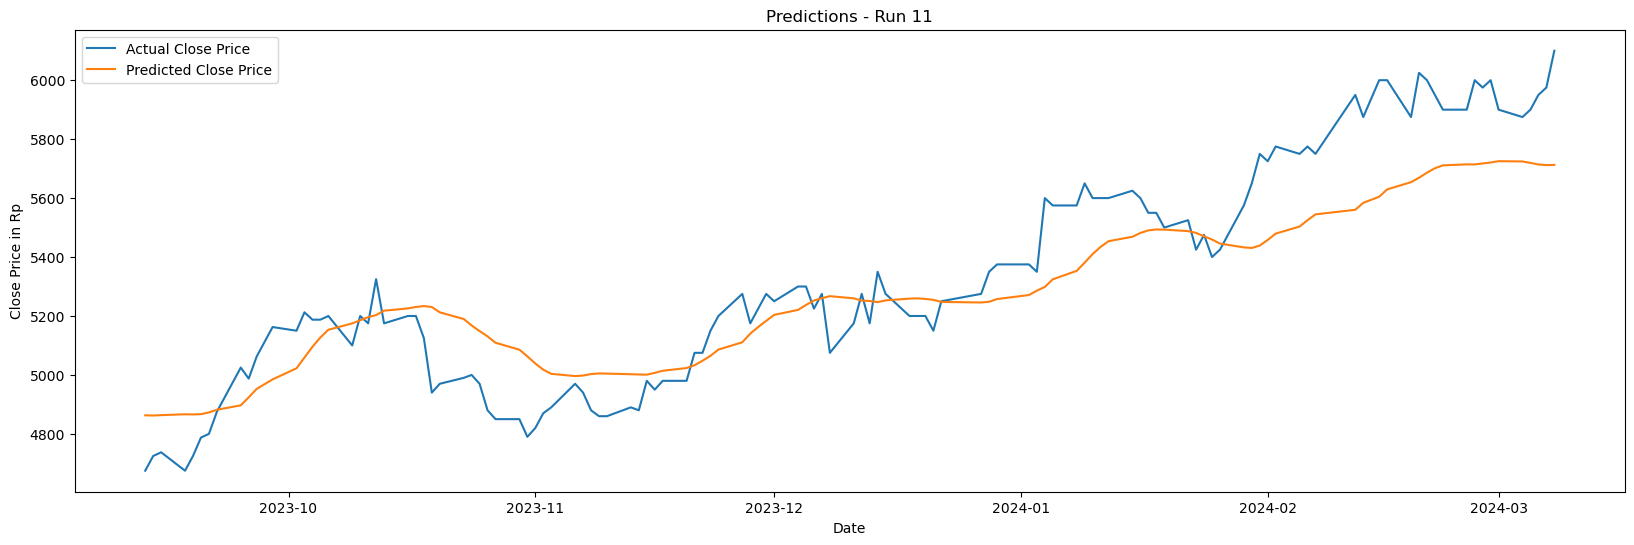

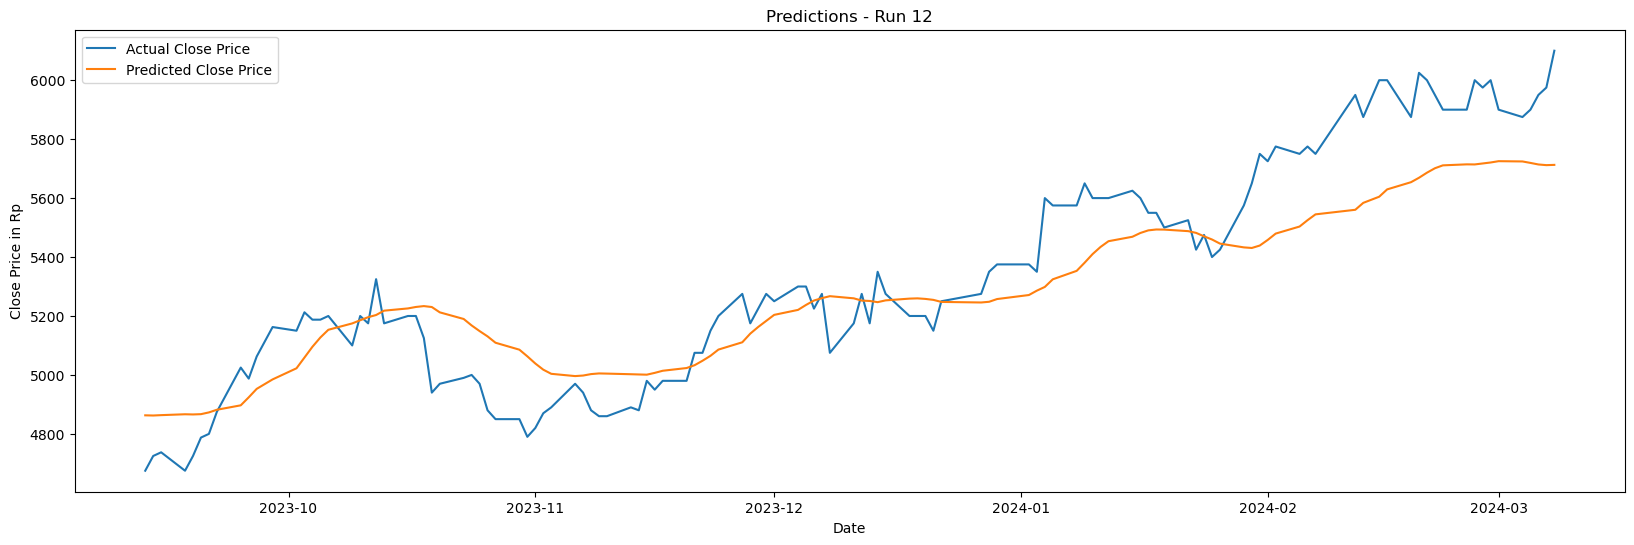

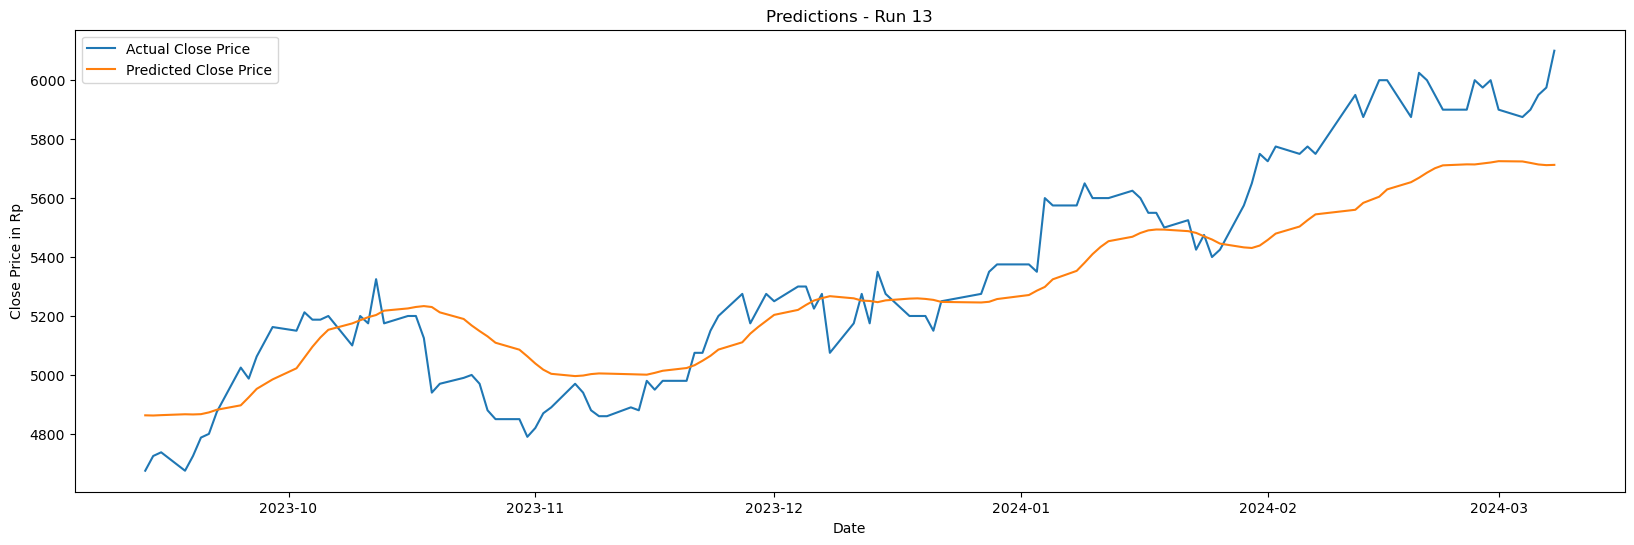

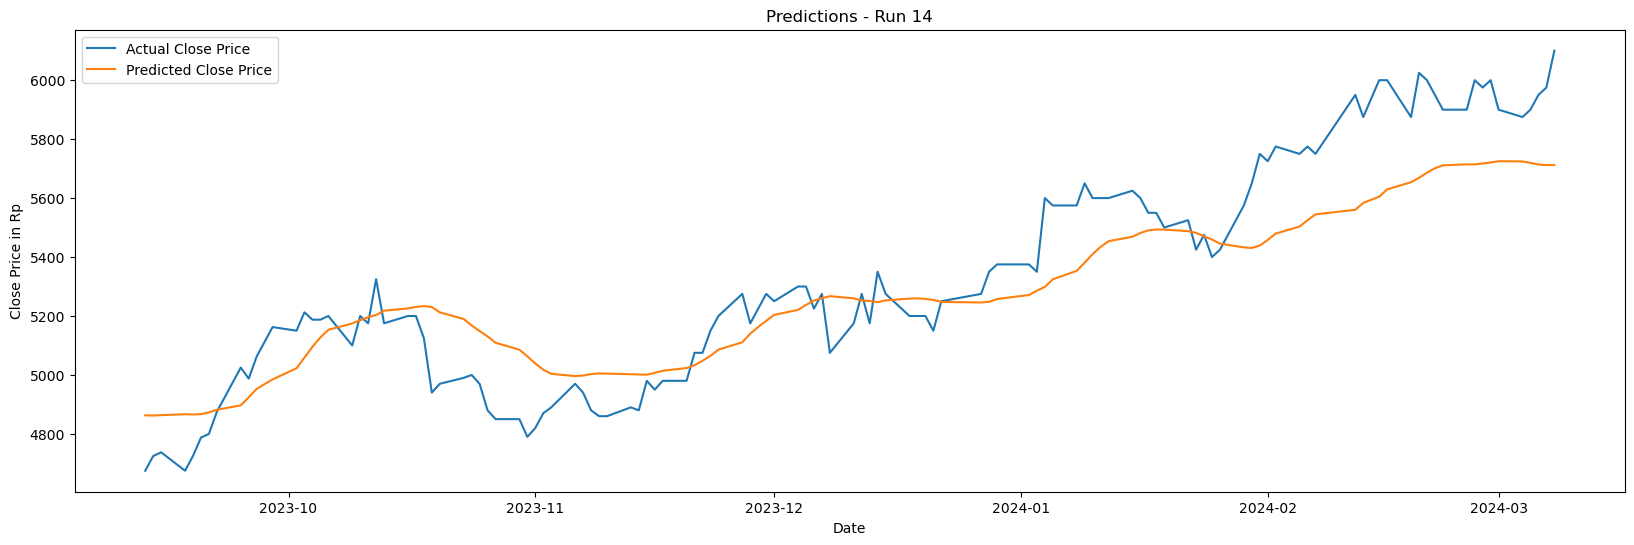

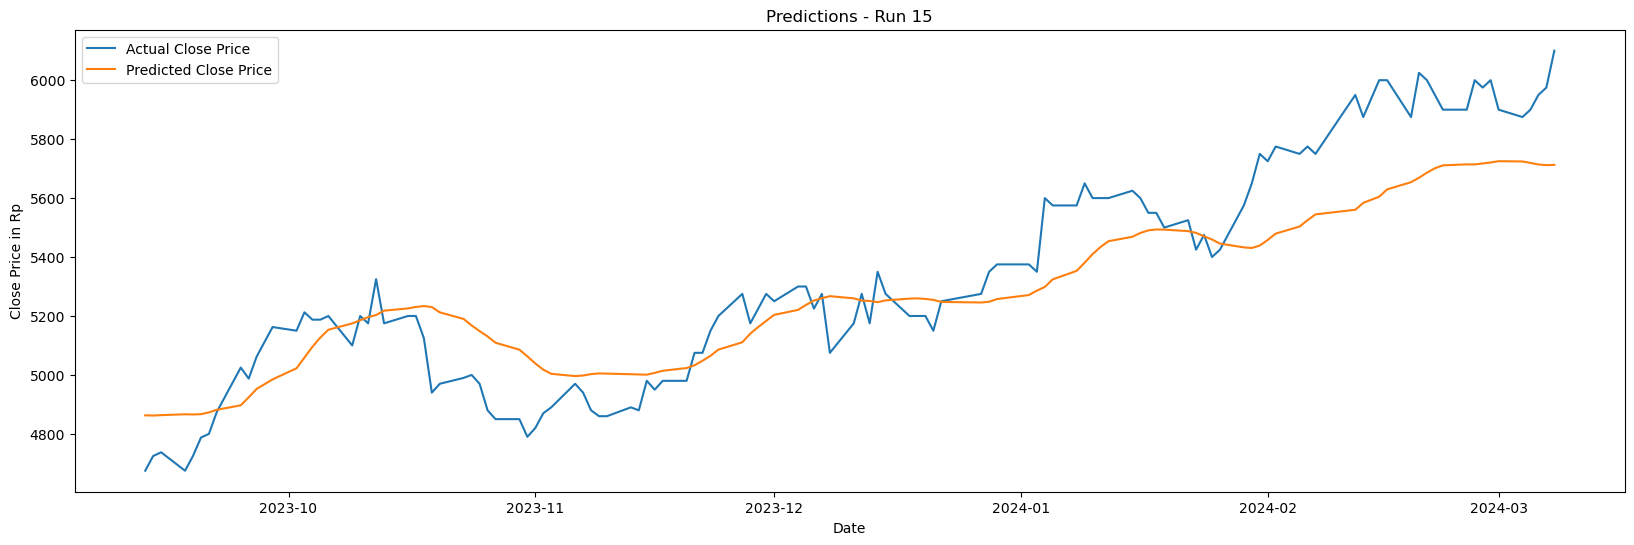

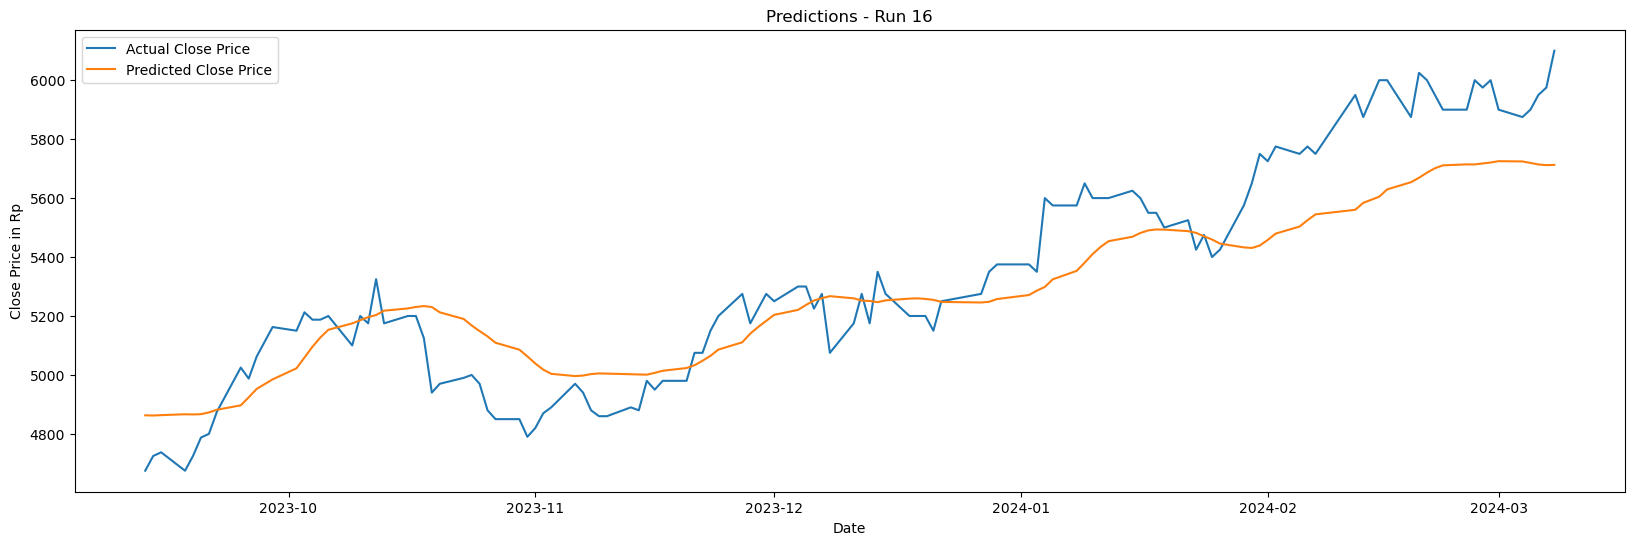

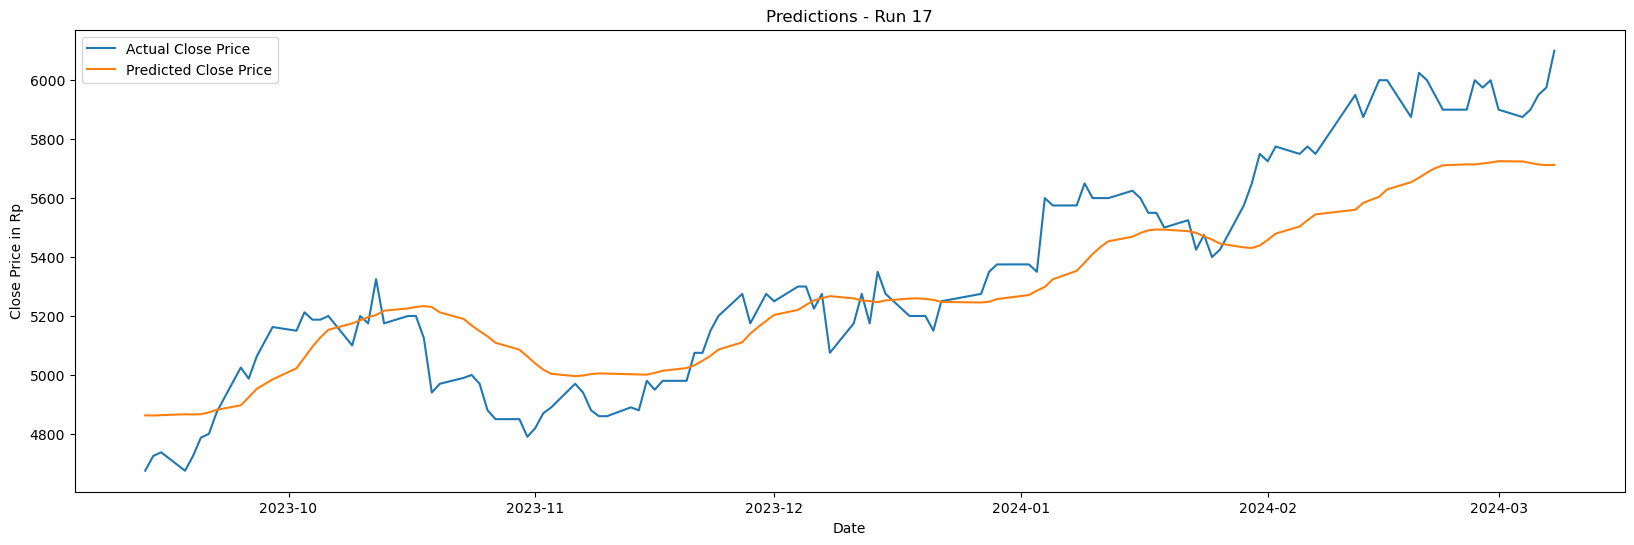

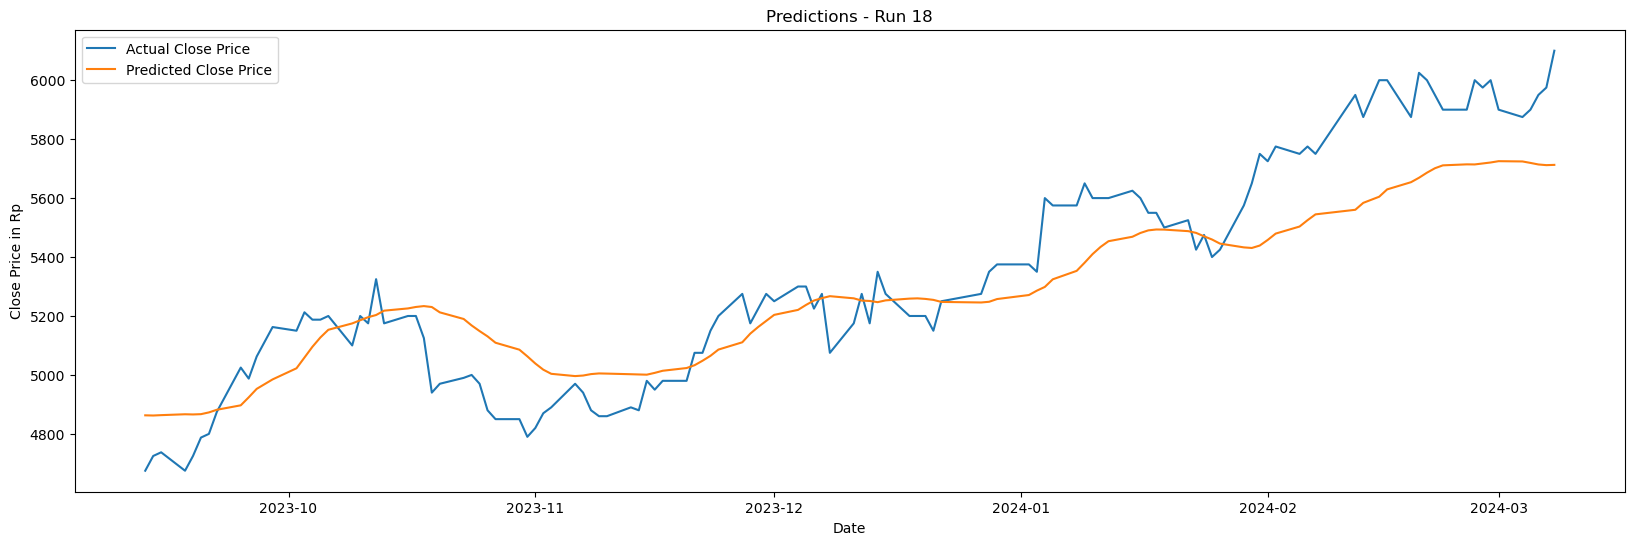

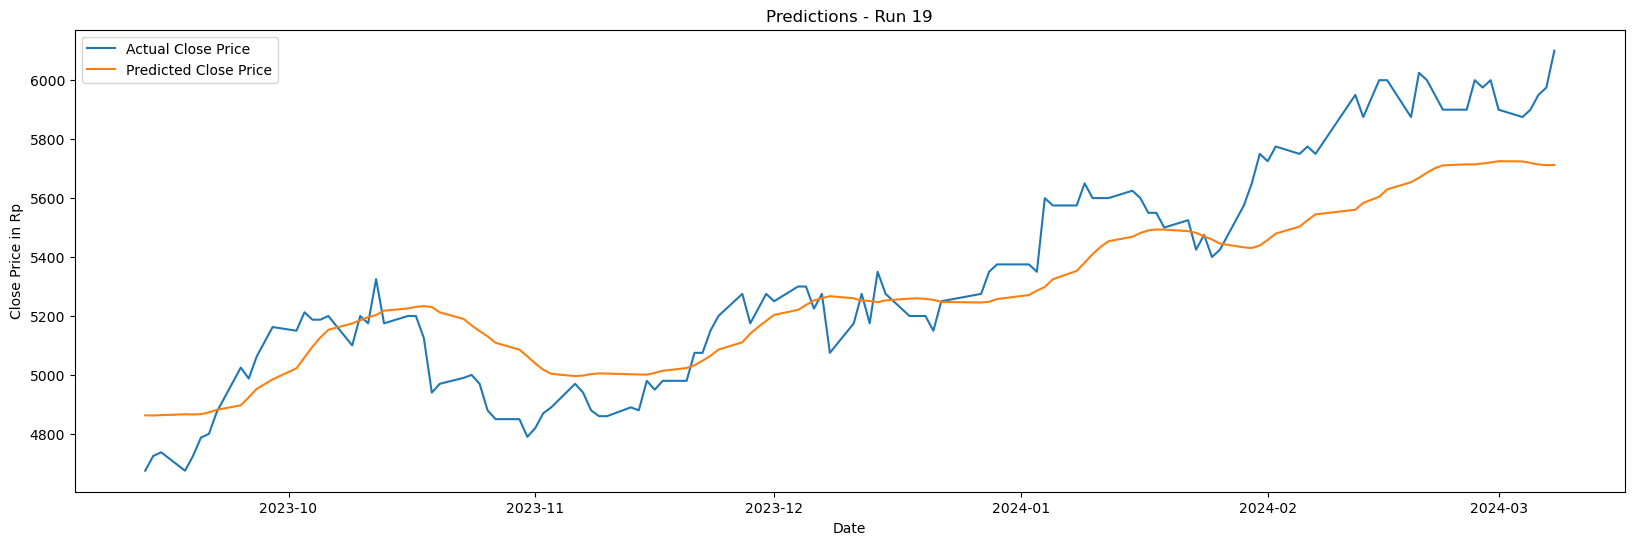

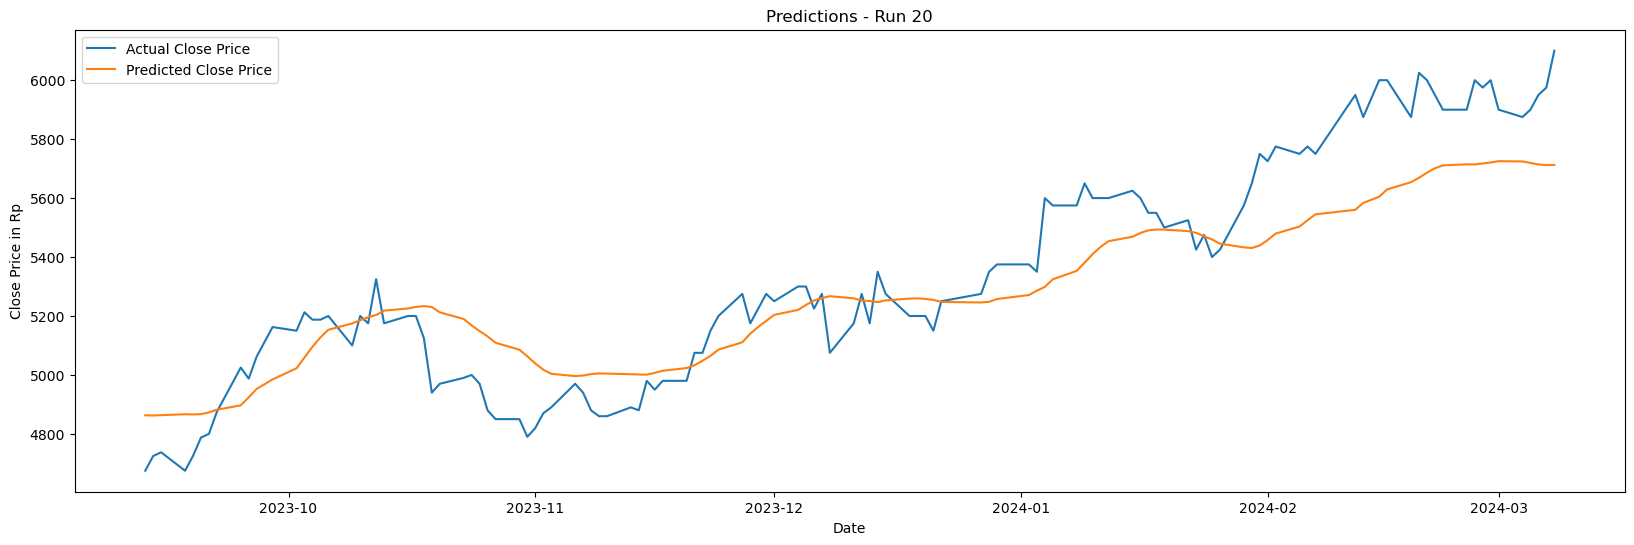

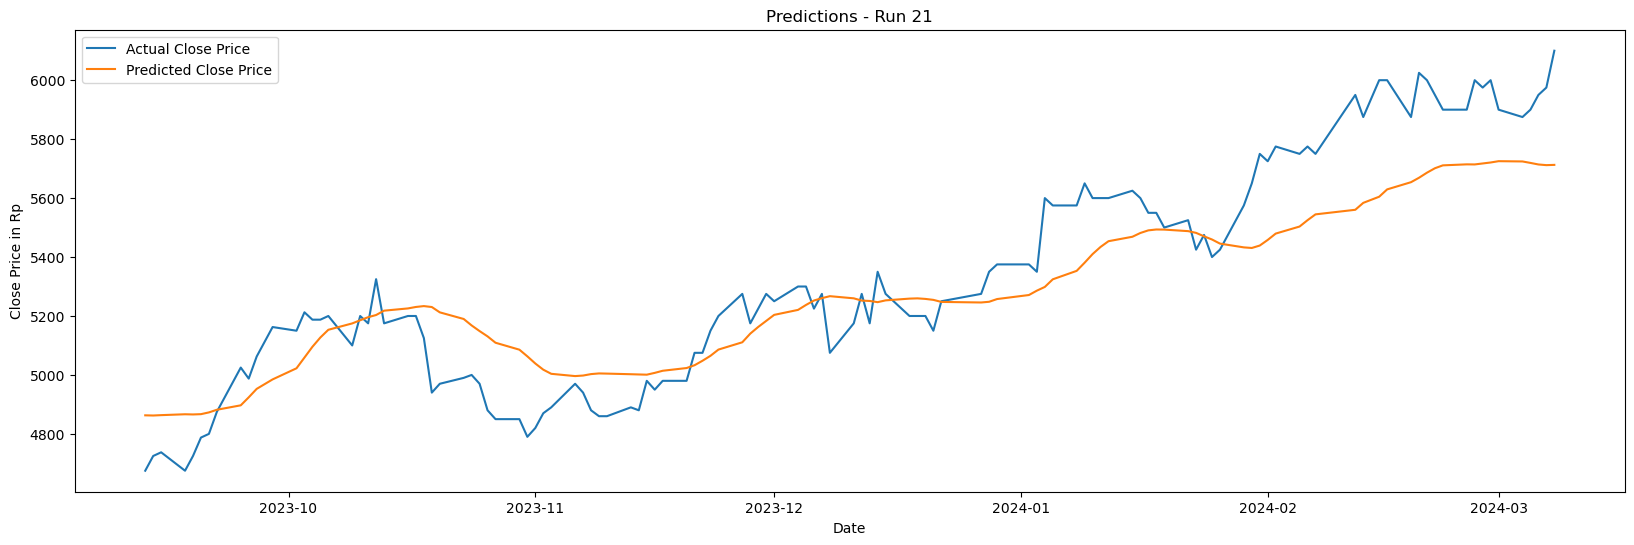

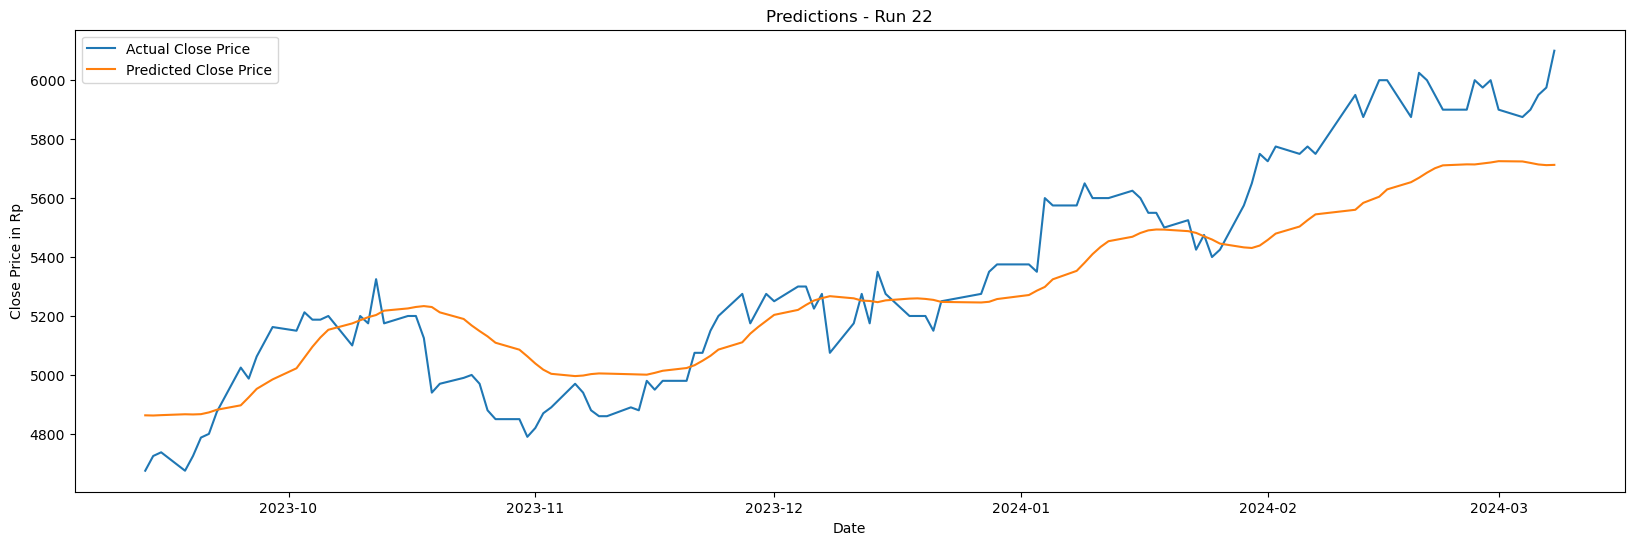

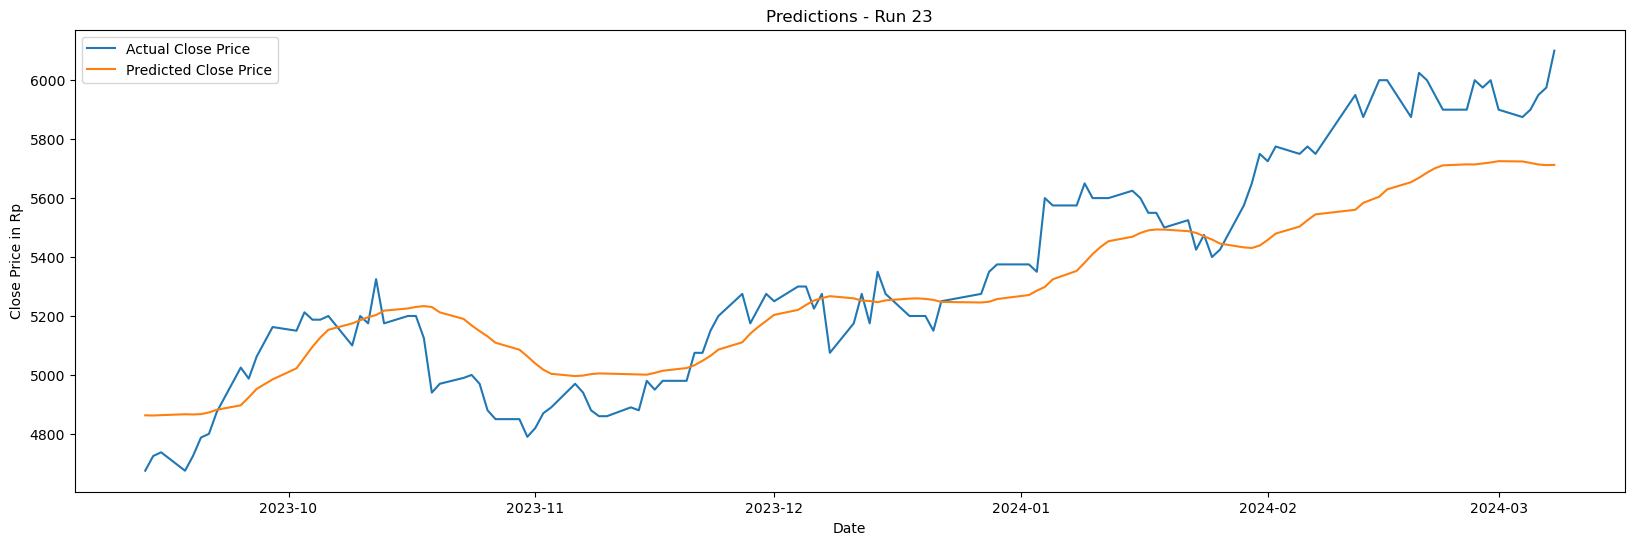

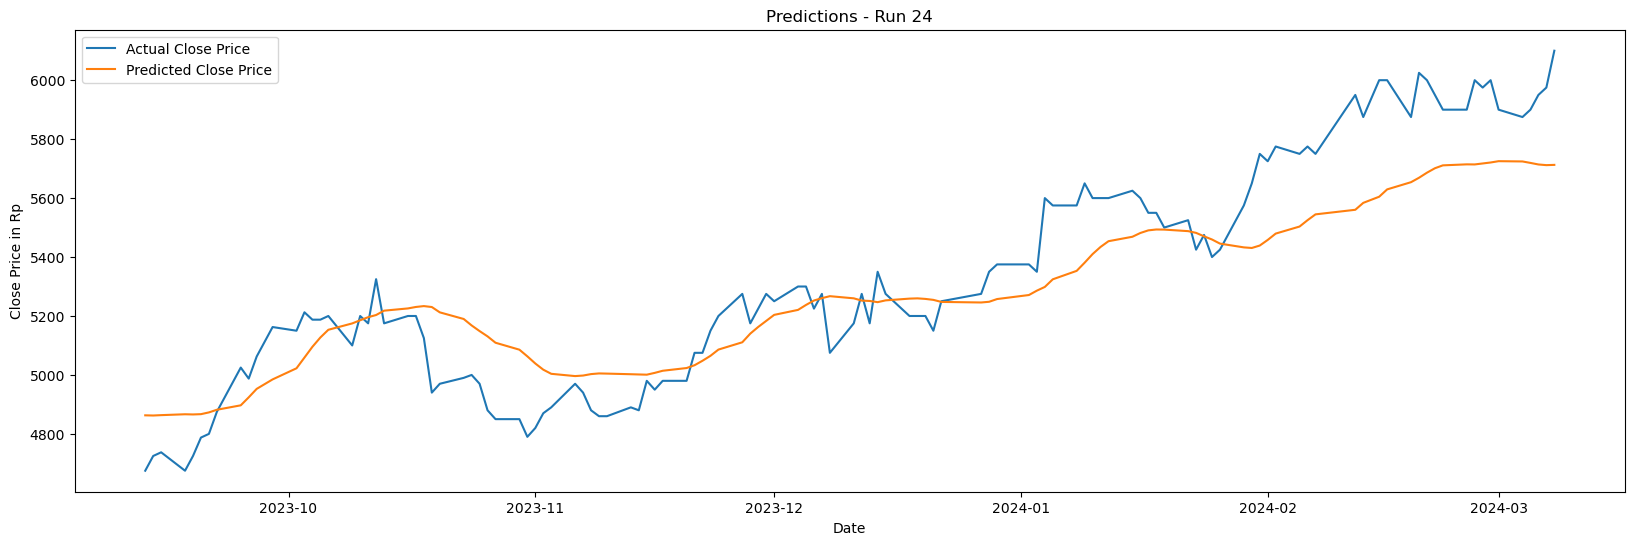

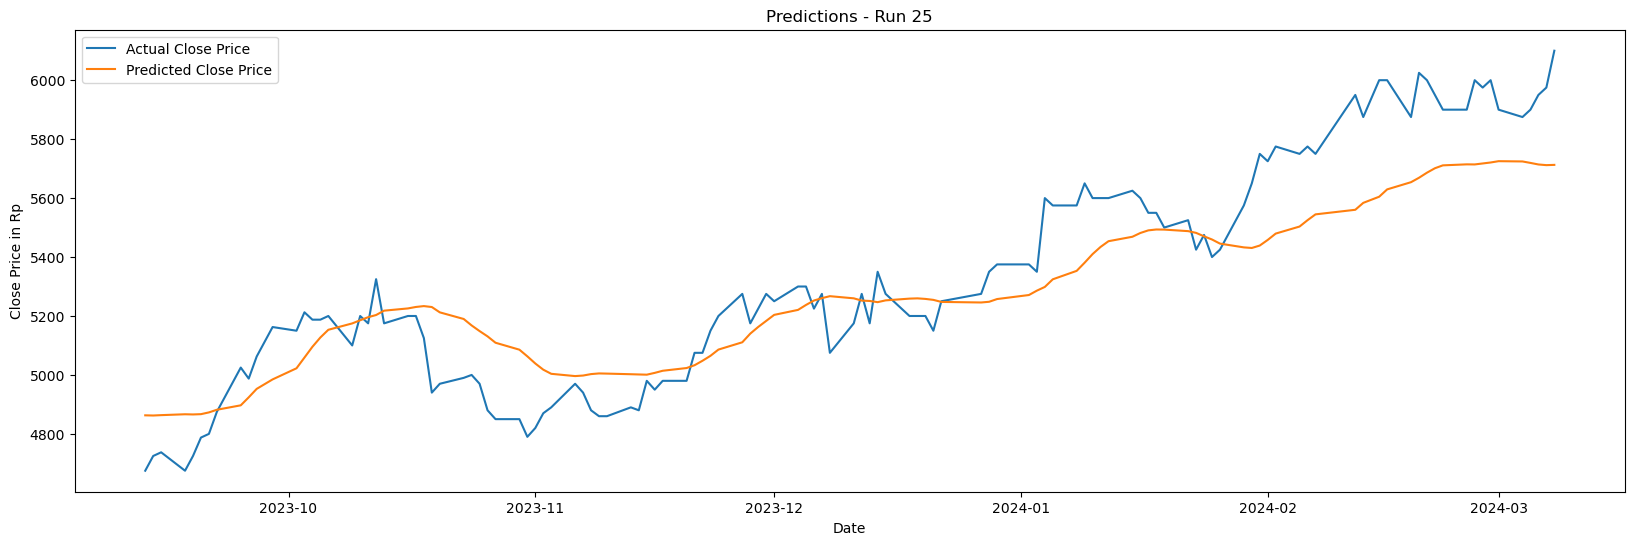

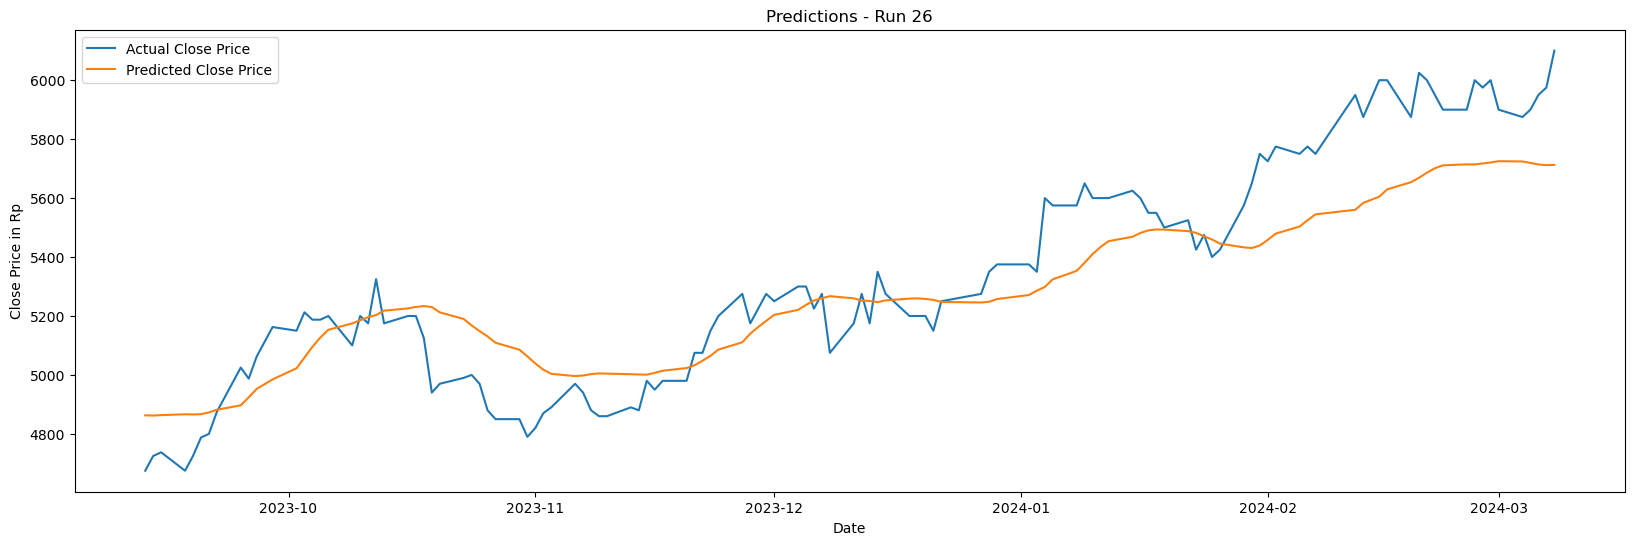

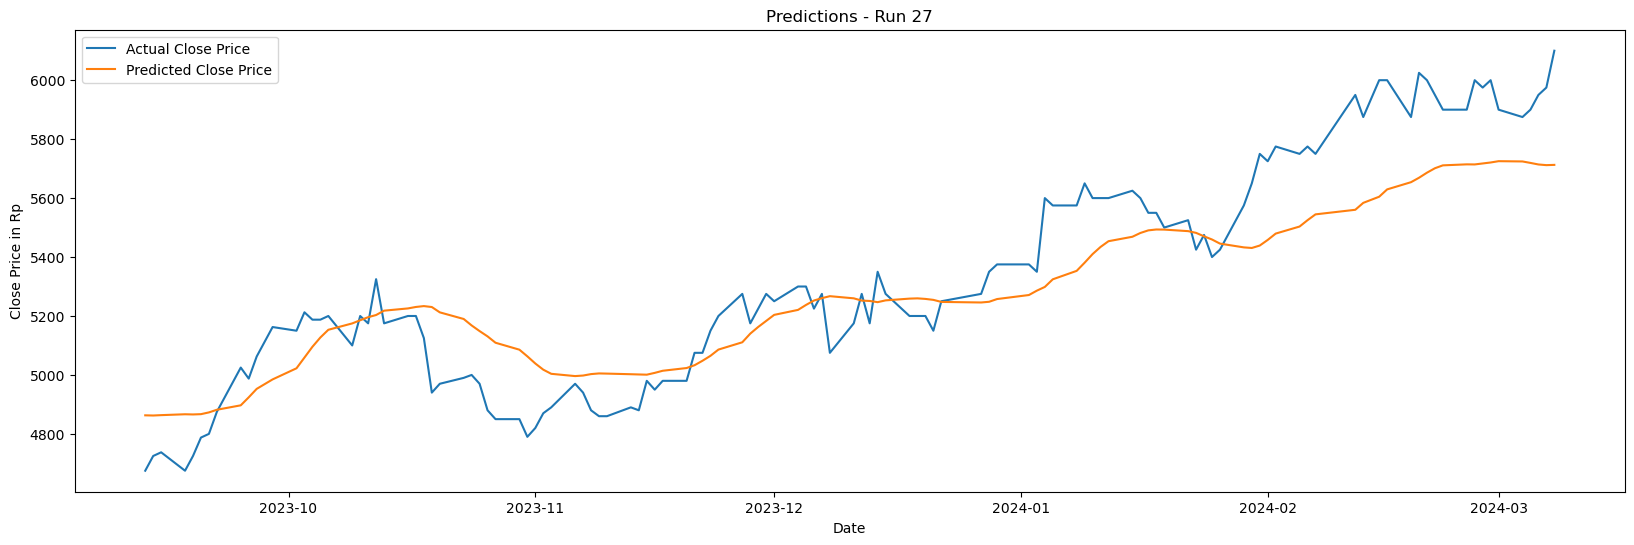

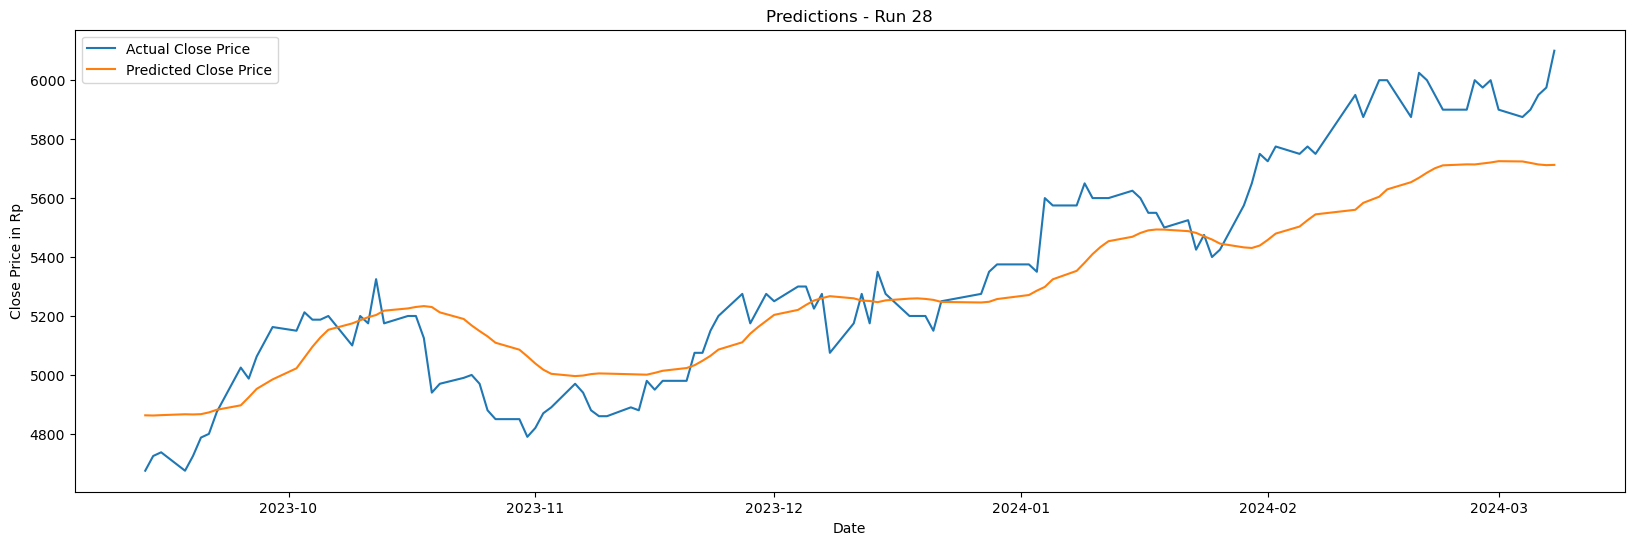

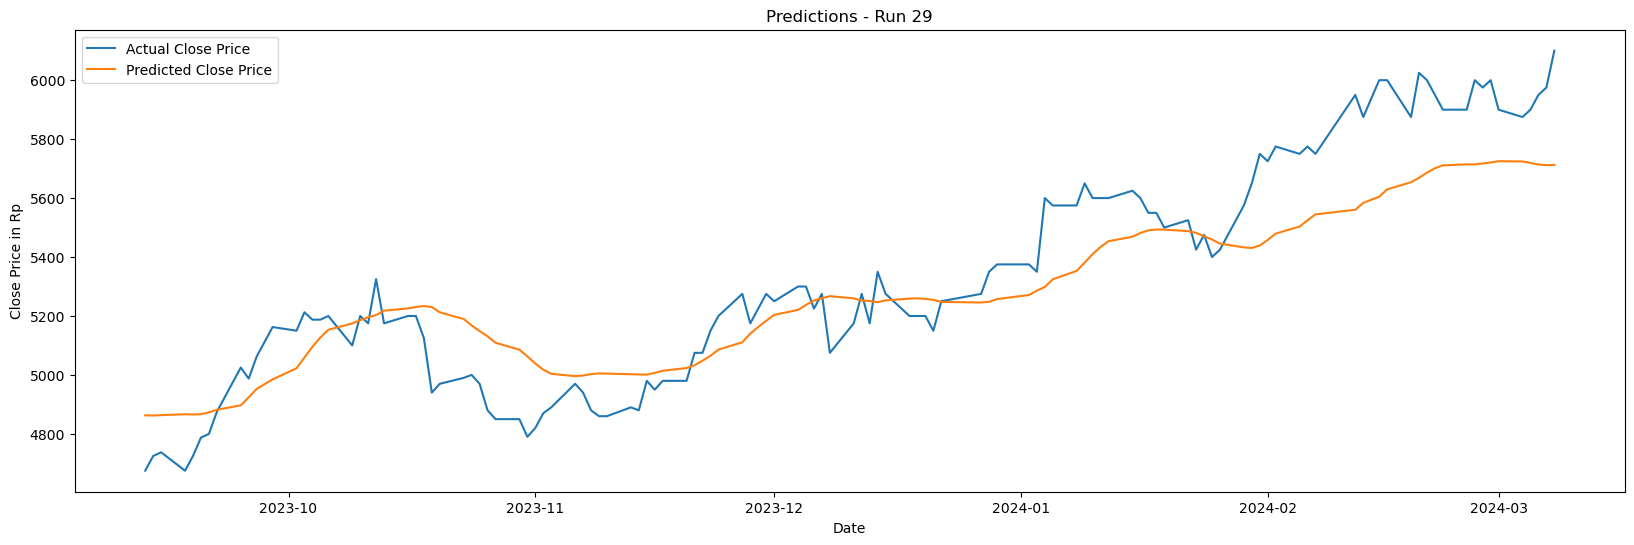

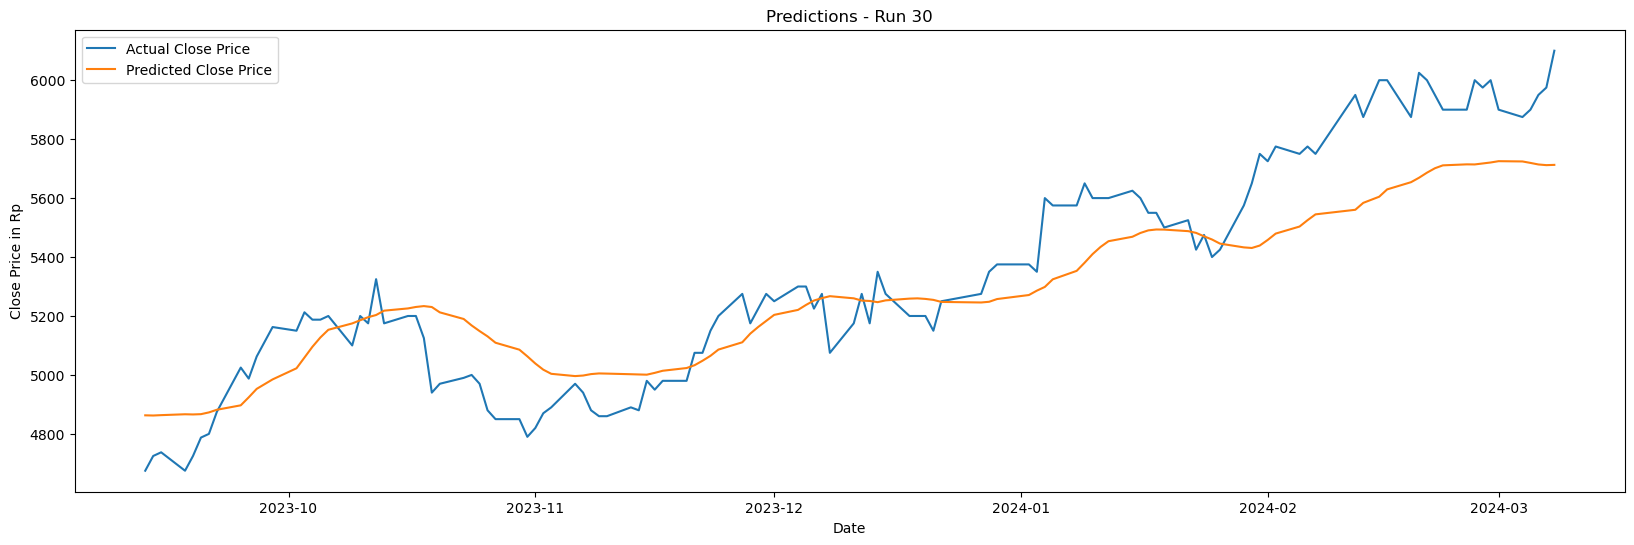

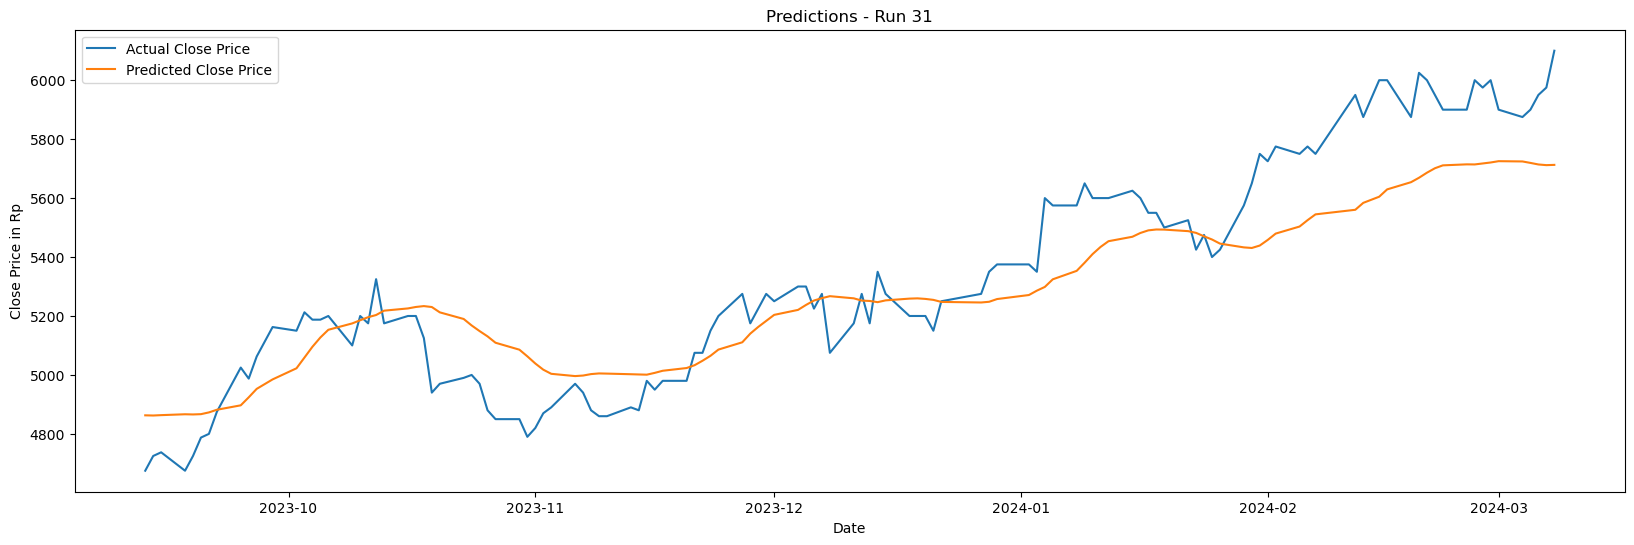

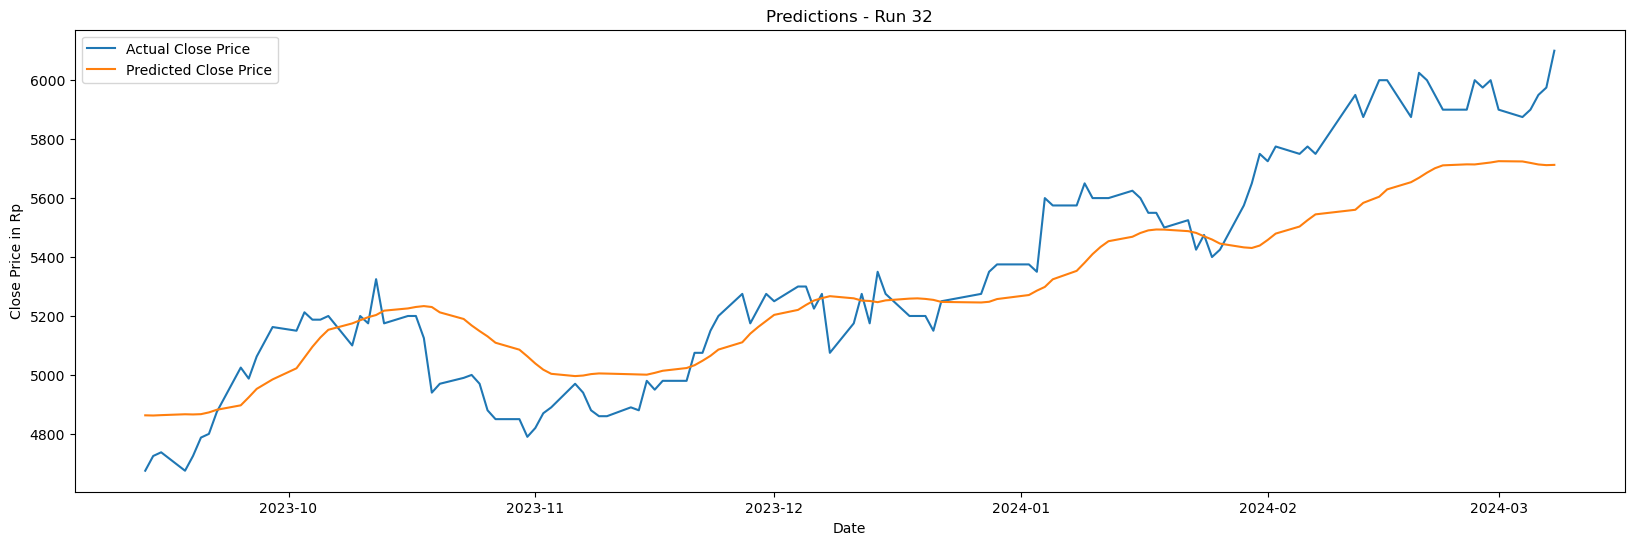

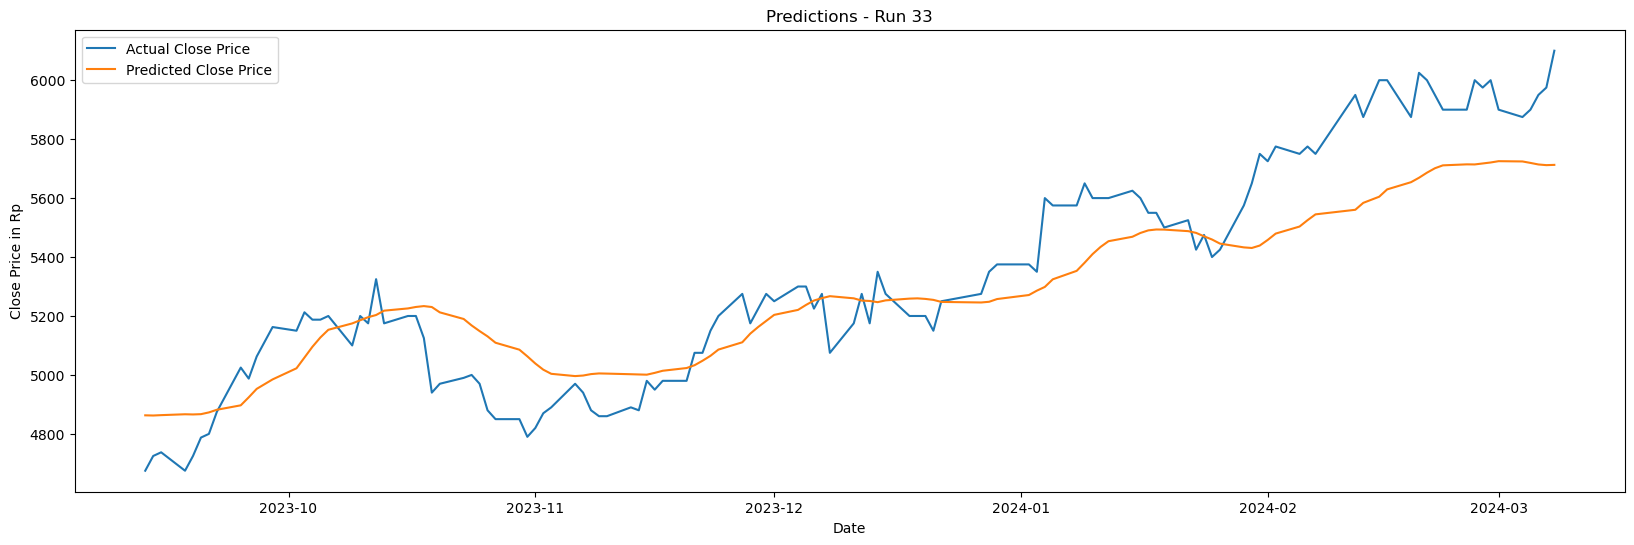

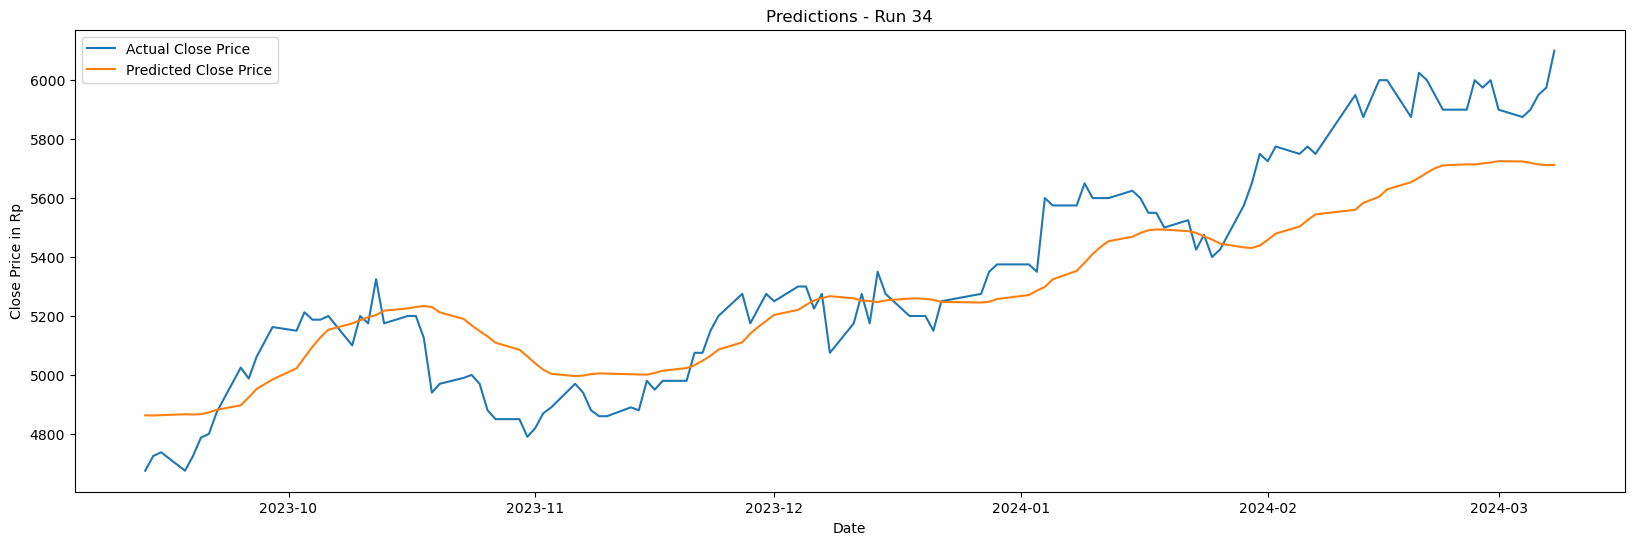

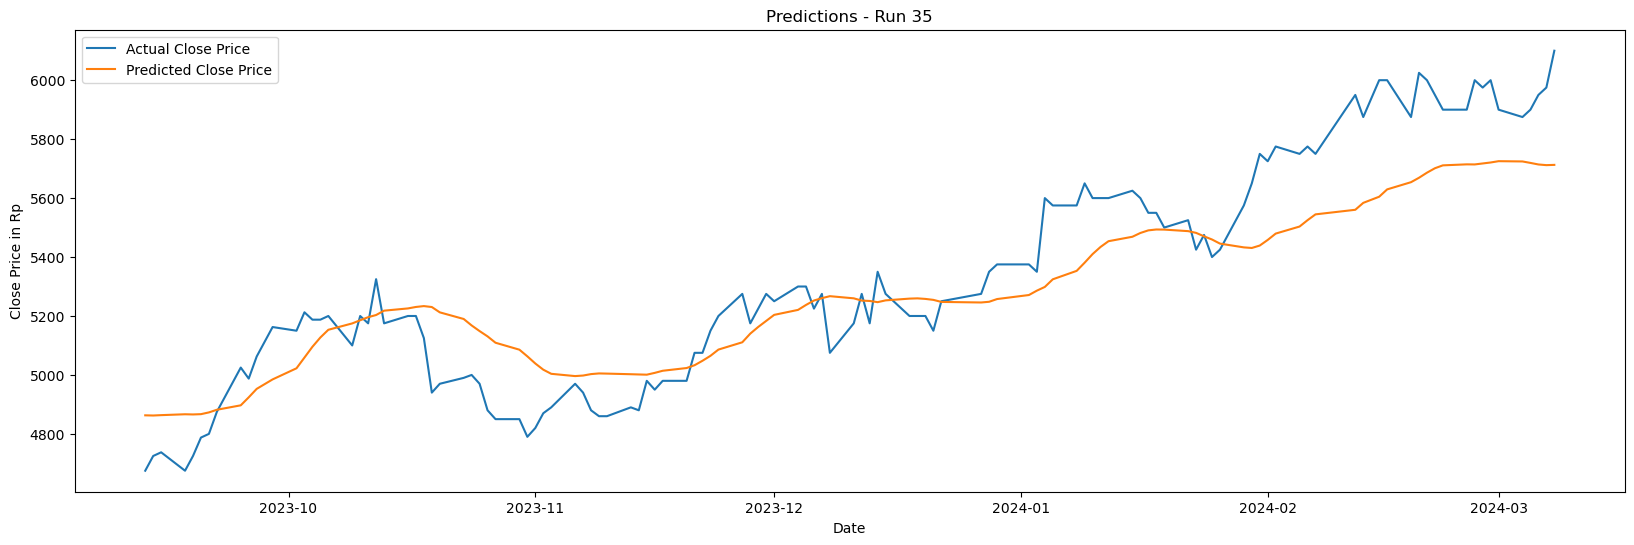

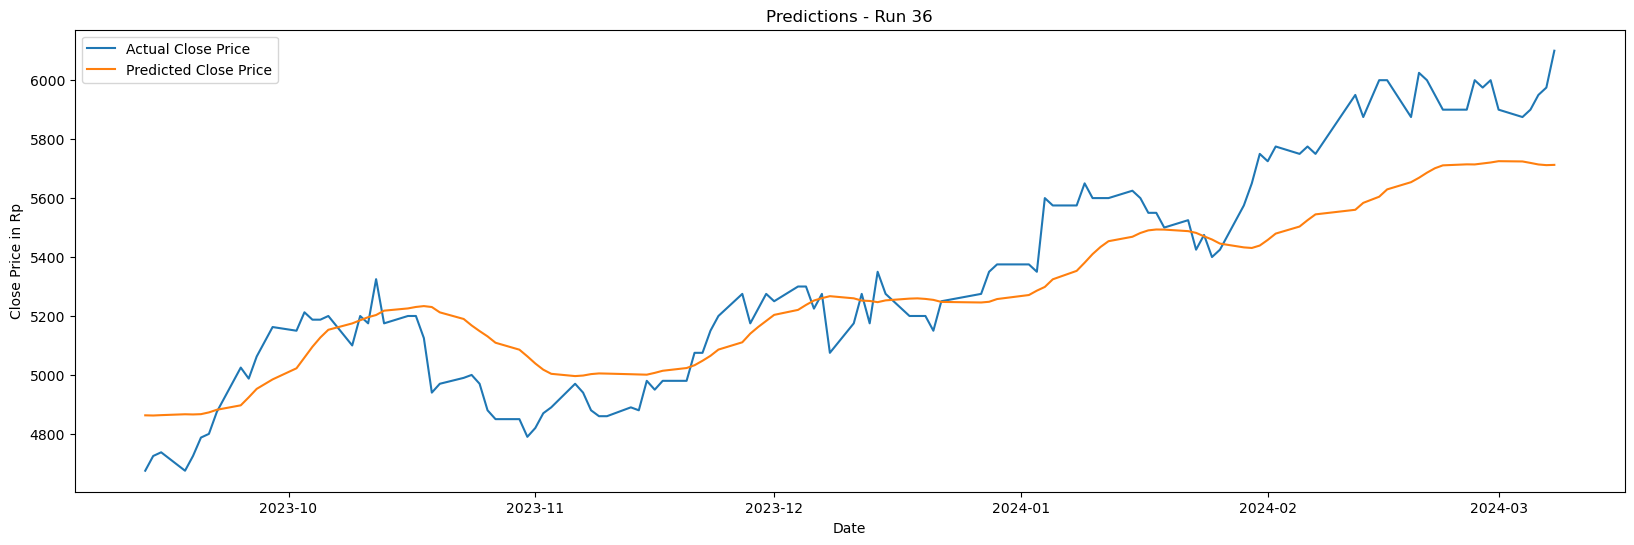

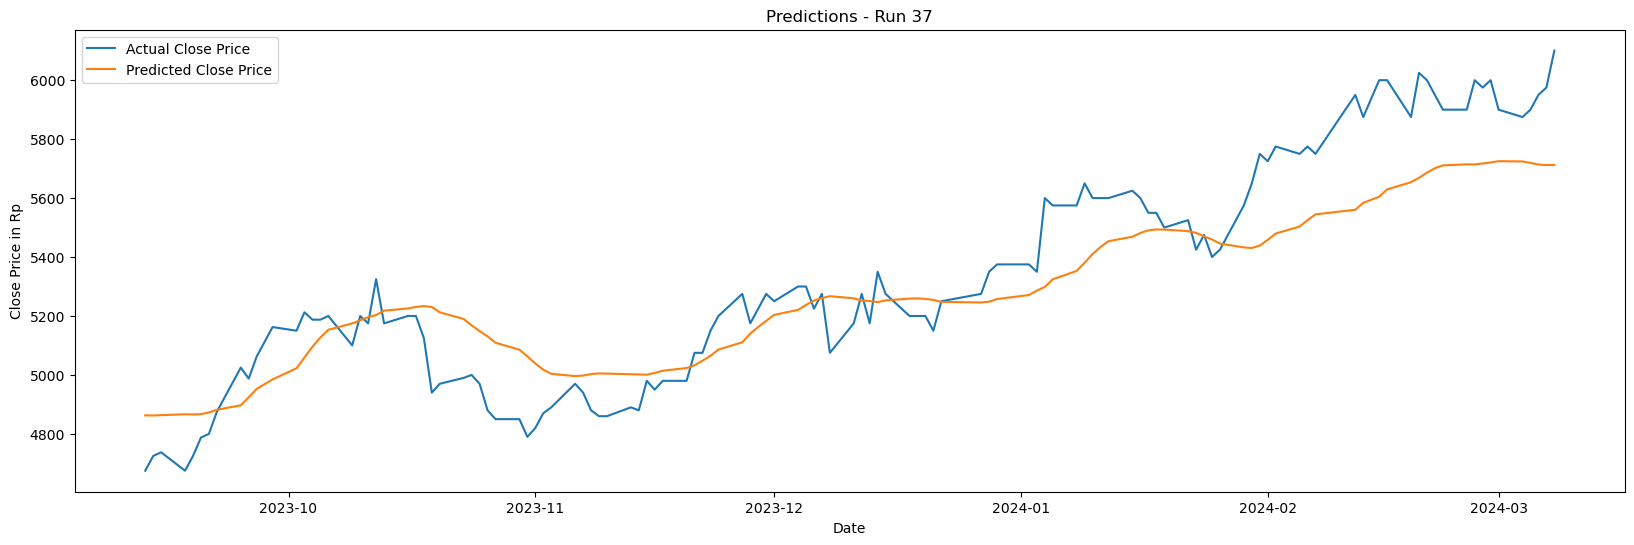

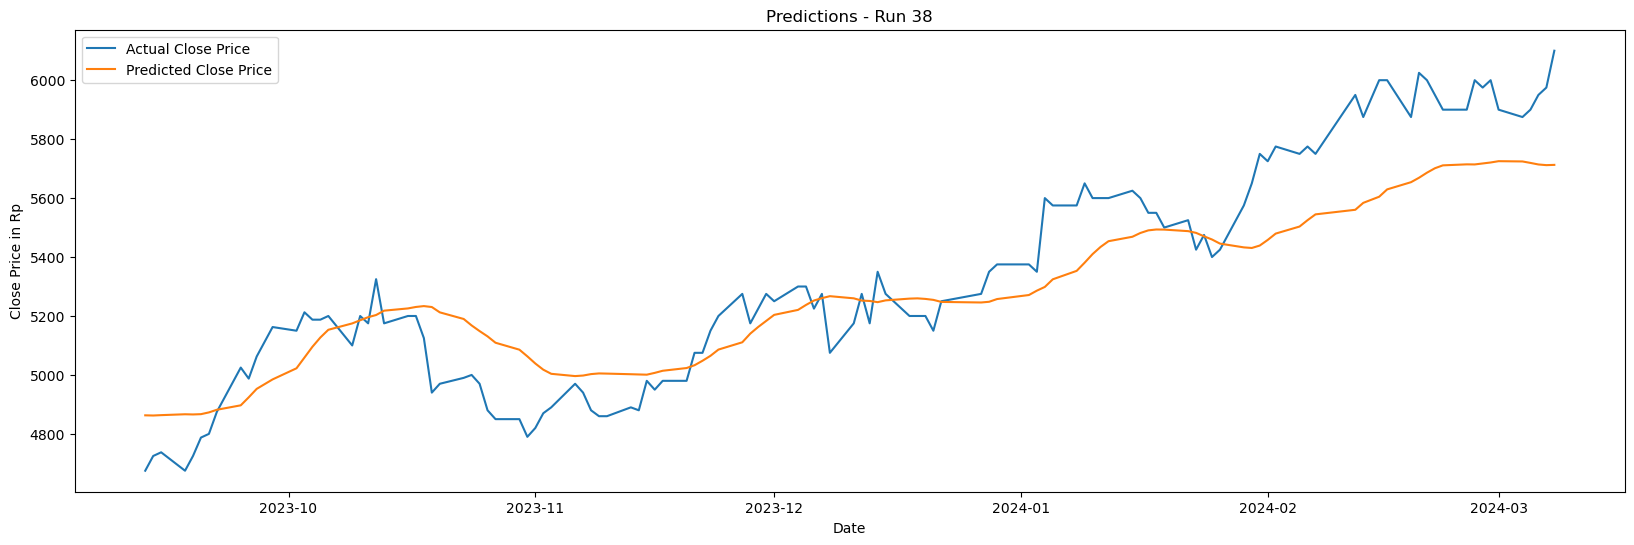

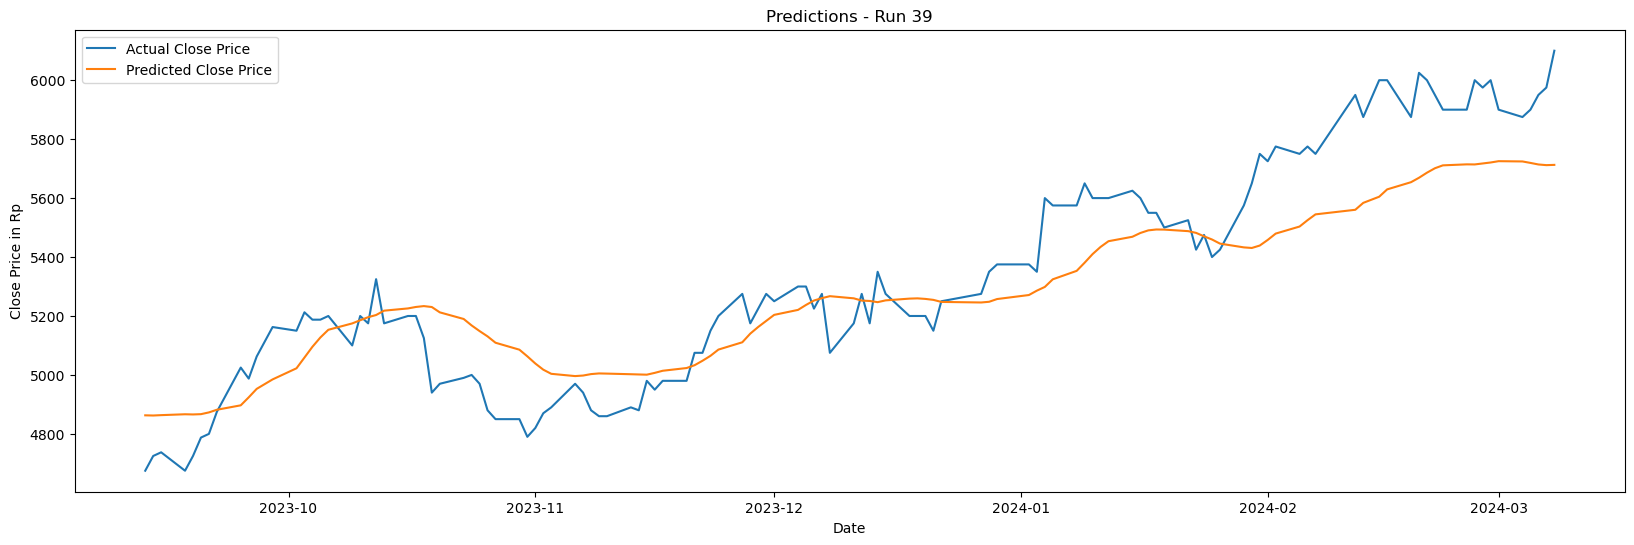

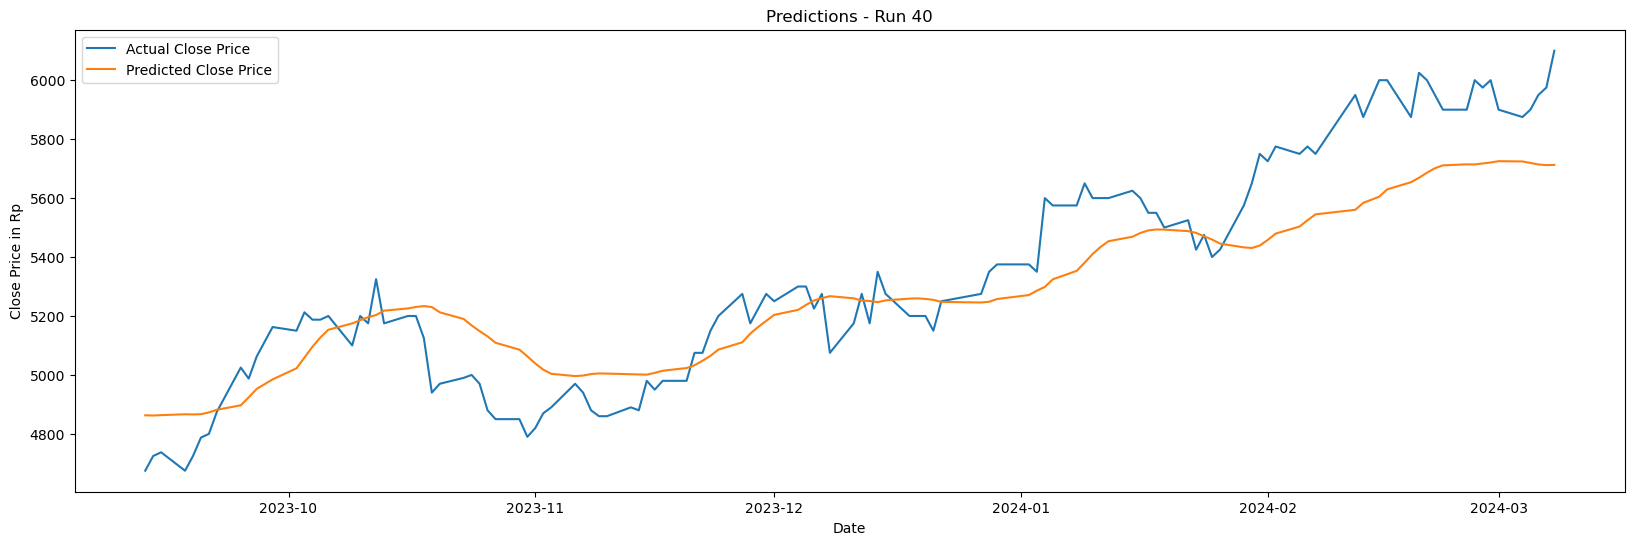

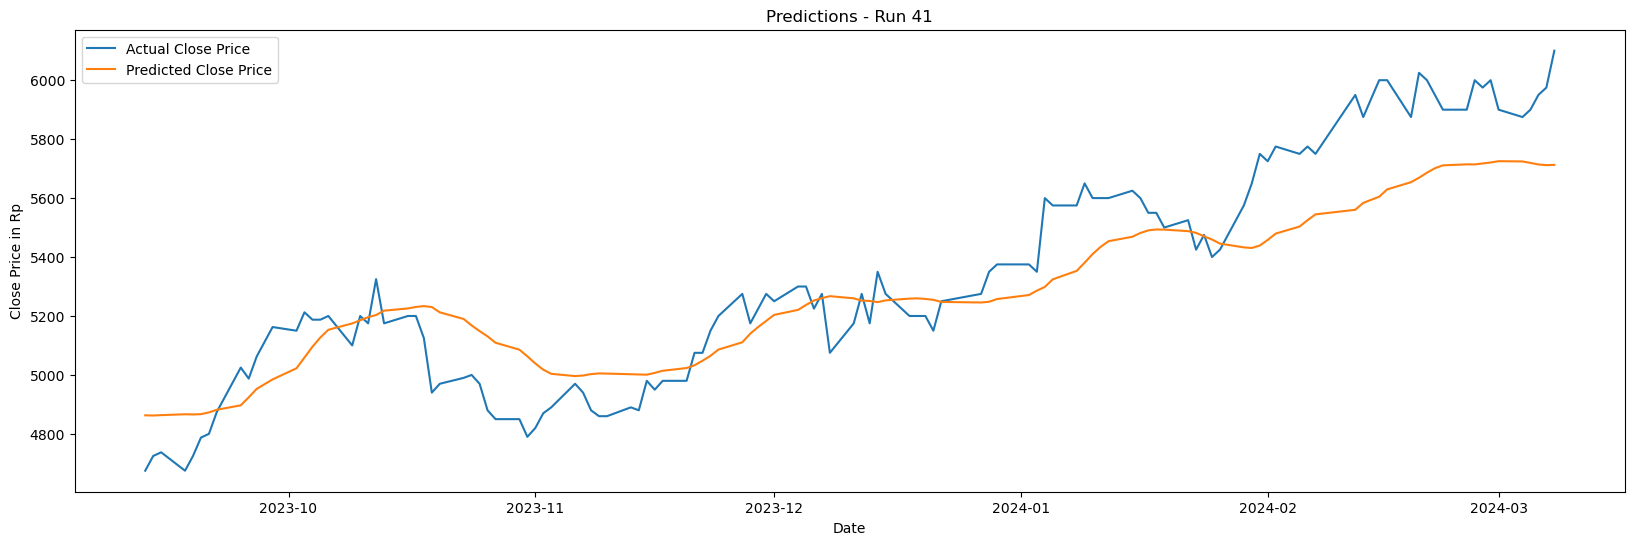

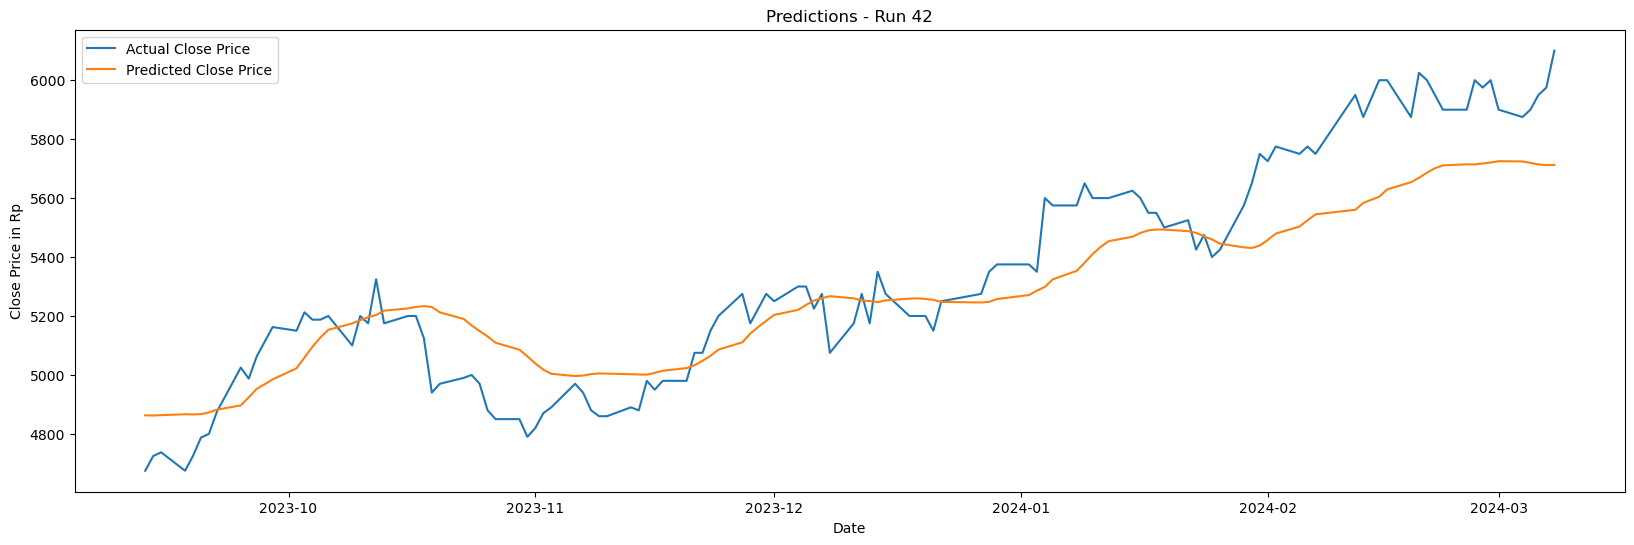

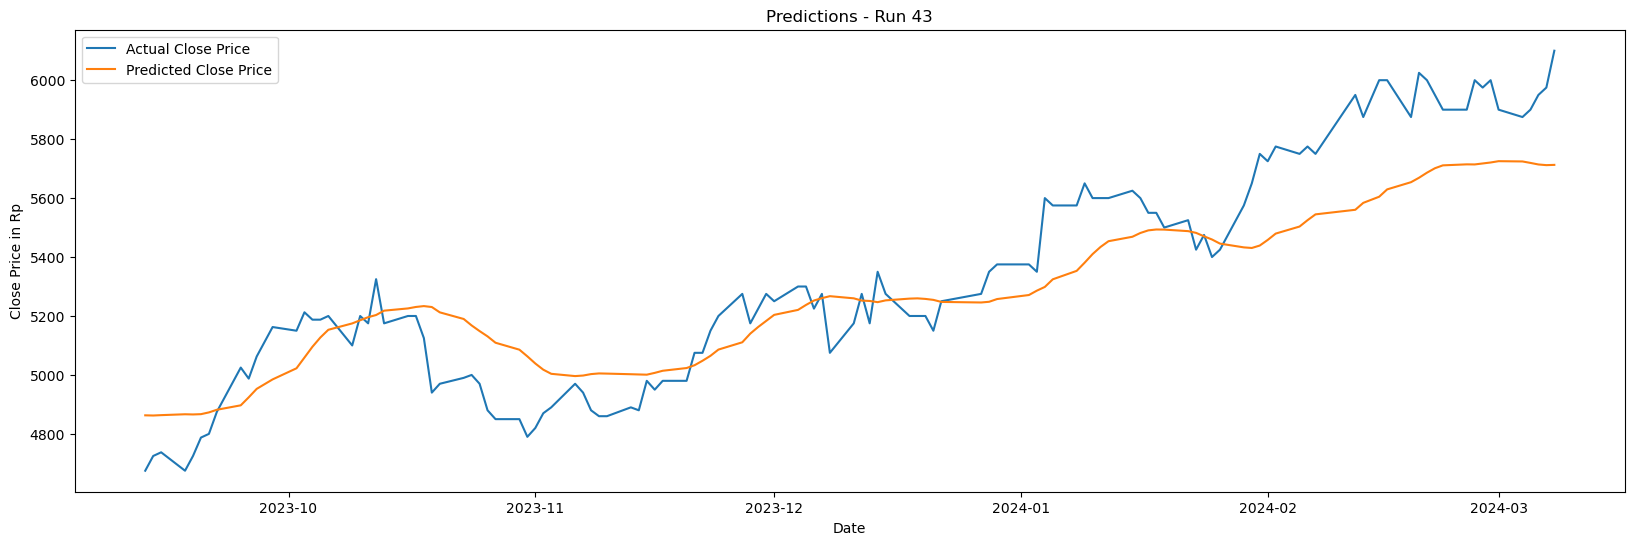

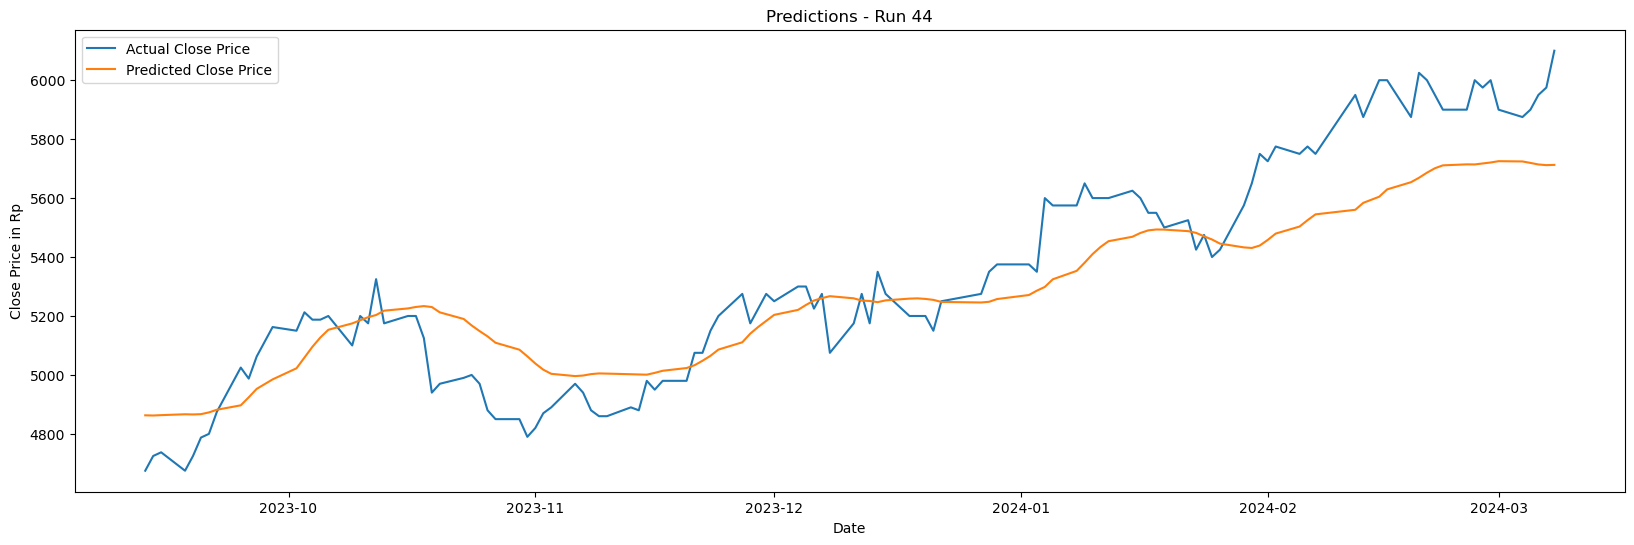

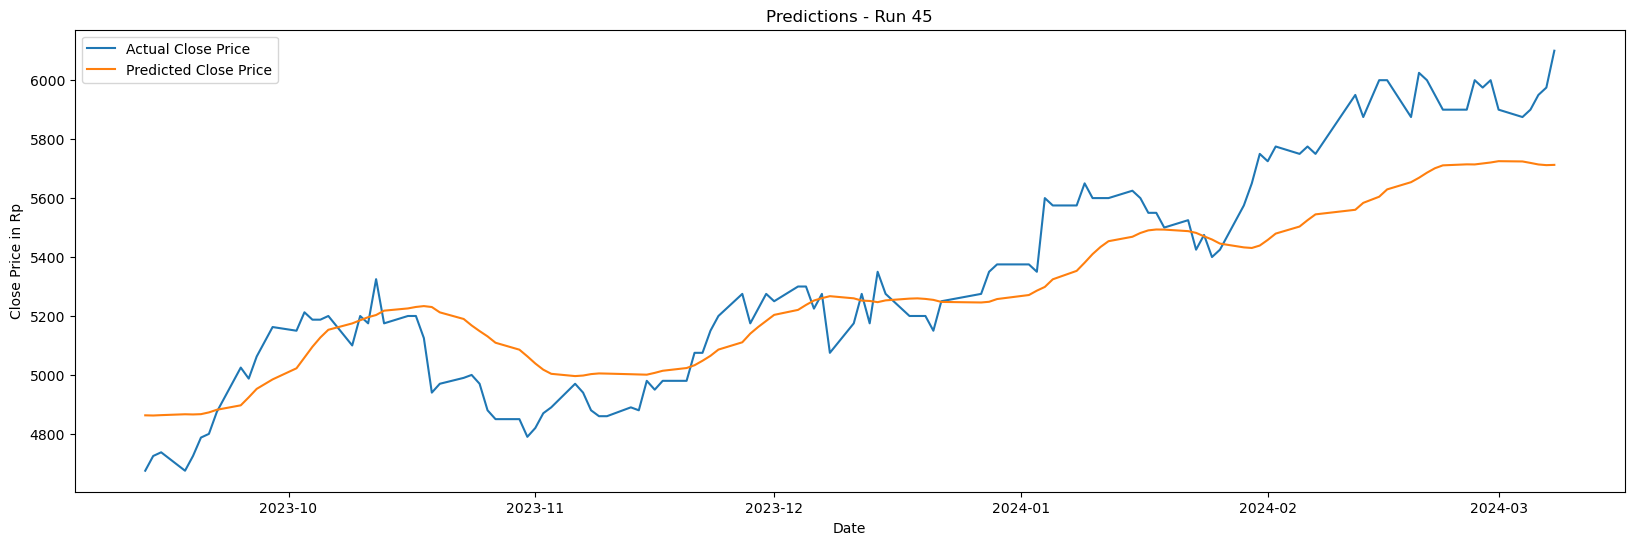

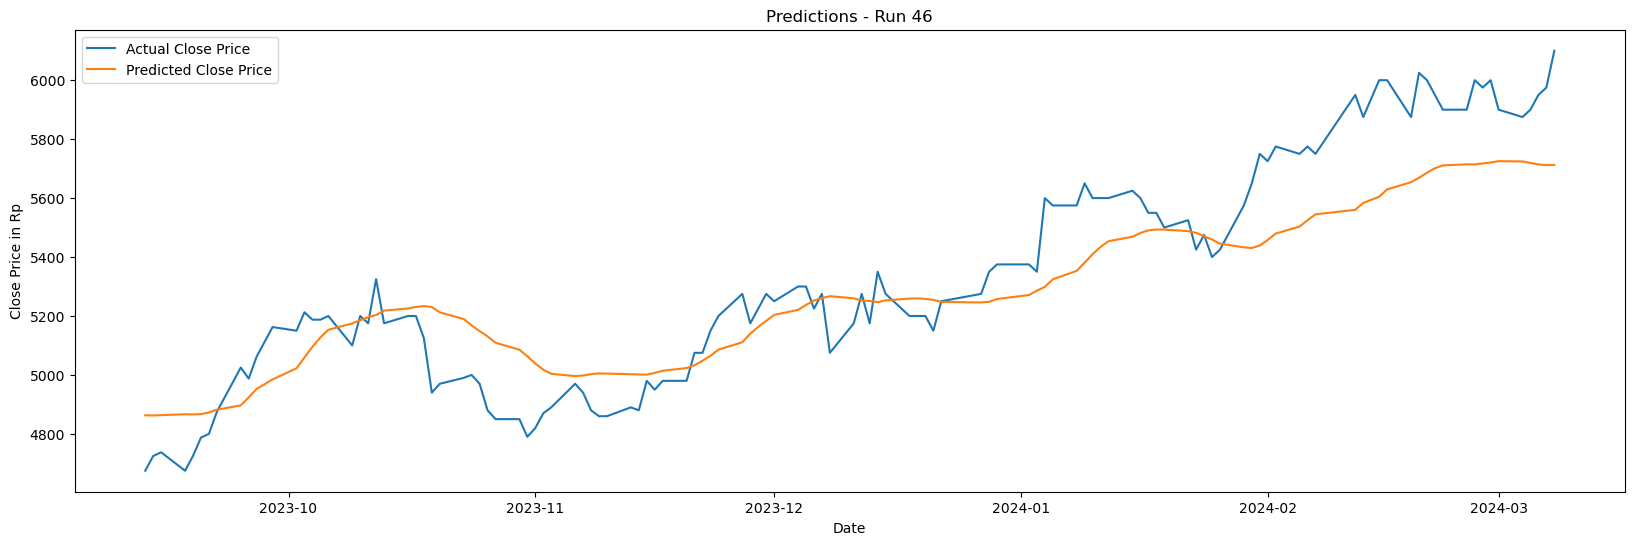

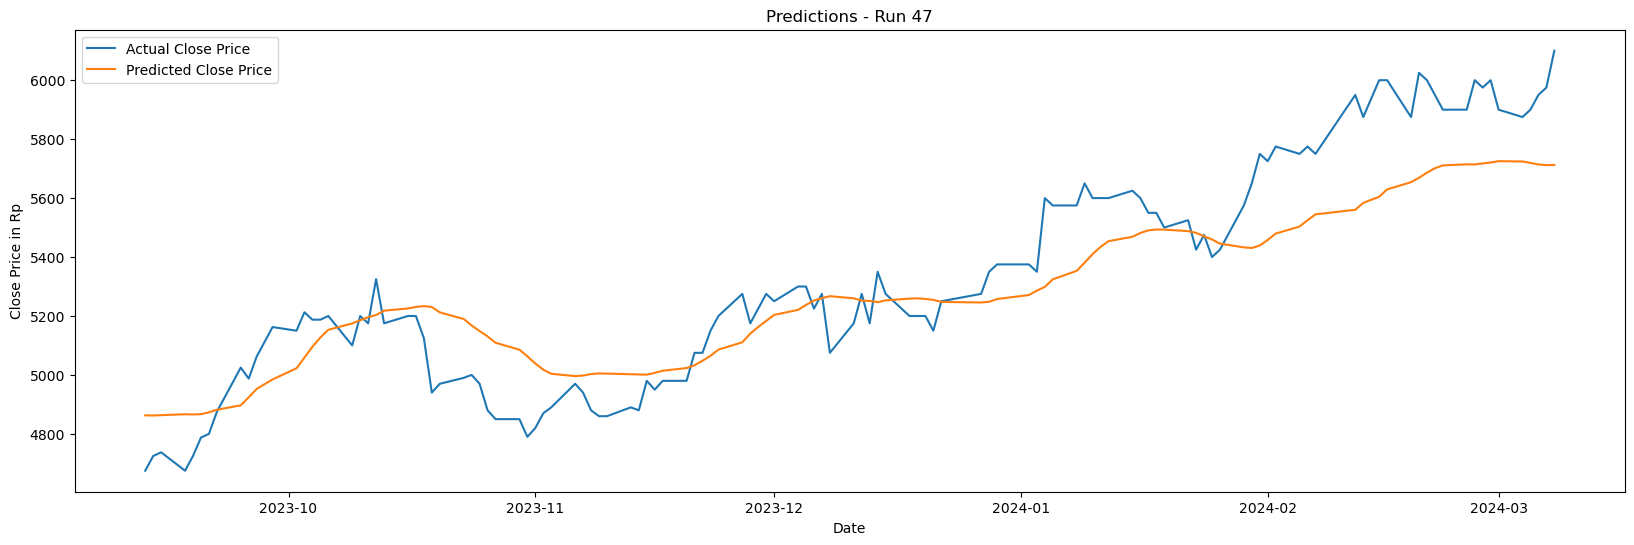

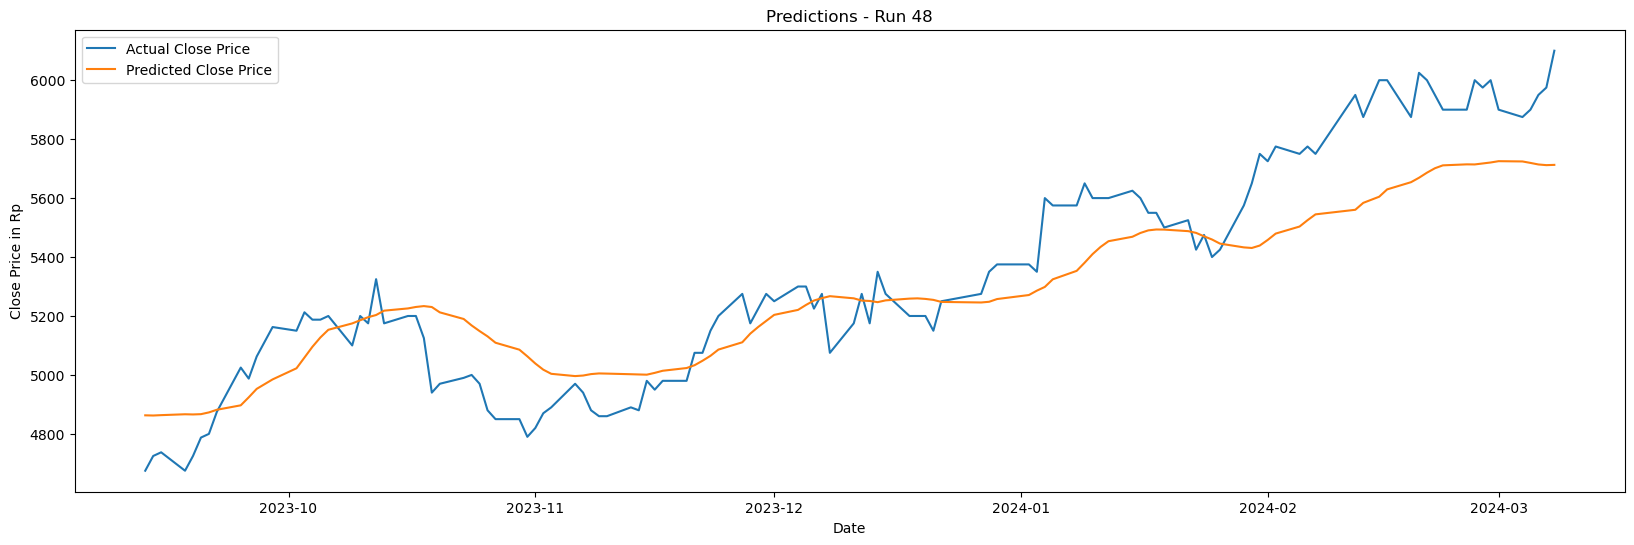

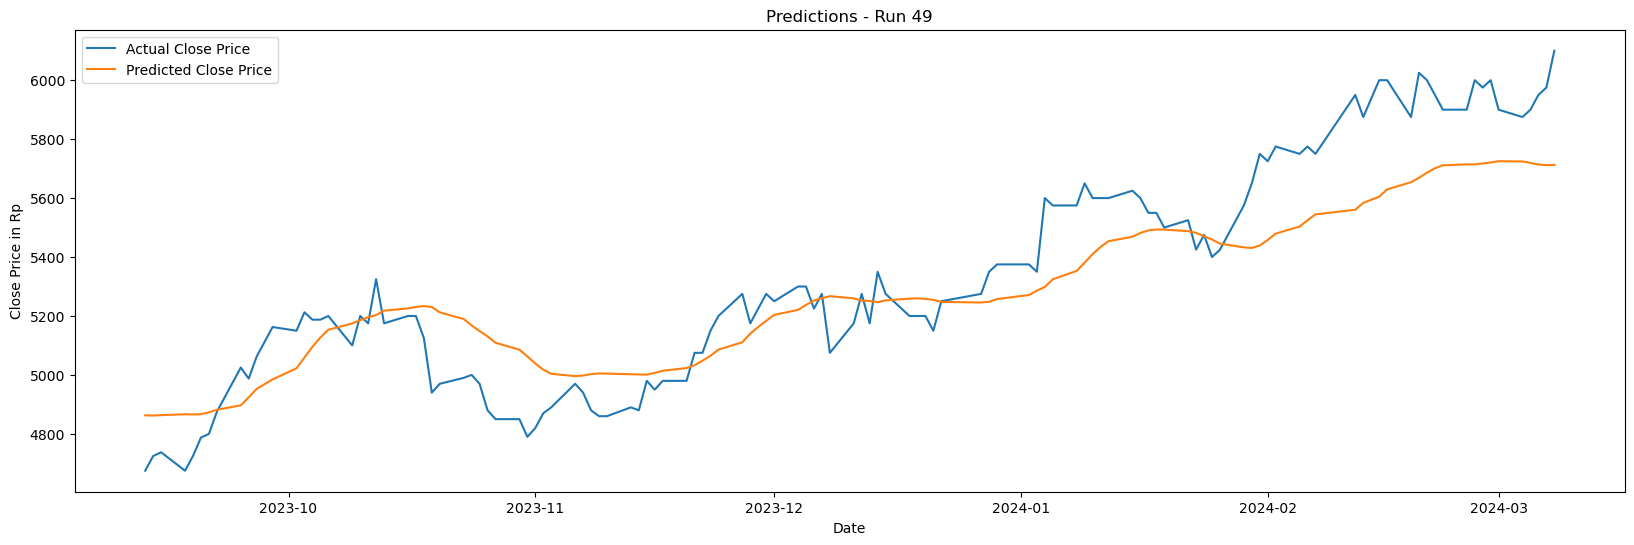

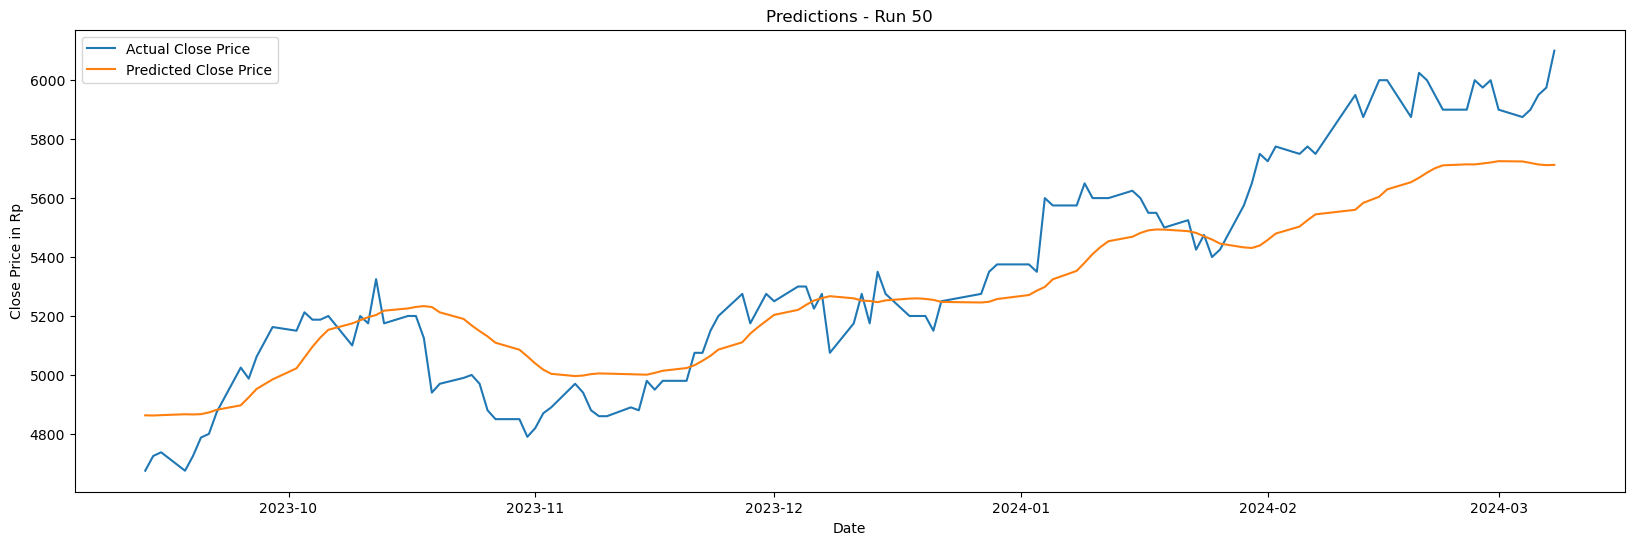

In [9]:
for i in range(50):
    # Plot predictions
    plt.figure(figsize=(20,6))
    plt.plot(data.index[training_data_len:], data['Close'][training_data_len:], label='Actual Close Price')
    plt.plot(data.index[training_data_len:], predictions, label='Predicted Close Price')
    plt.title(f'Predictions - Run {i+1}')
    plt.xlabel('Date')
    plt.ylabel('Close Price in Rp')
    plt.legend()
    plt.show()

In [10]:
# Ambil kolom 'Average_Prediction'
average_prediction = results_df['Average_Prediction'].copy()

# Hapus 2 baris terakhir dari 'average_prediction'
average_prediction = average_prediction.iloc[:-2]

# Buat DataFrame baru dengan kolom 'Average_Prediction'
new_dataframe = pd.DataFrame(average_prediction, columns=['Average_Prediction'])

# Atur kolom 'Date' dari data sebagai indeks
new_dataframe.index = data.index[training_data_len:]

# Tambahkan kolom 'Actual' dari data asli
new_dataframe['Actual'] = data['Close'][training_data_len:]  

# Tampilkan DataFrame baru
print(new_dataframe)

            Average_Prediction  Actual
Date                                  
2023-09-13         4828.969658  4675.0
2023-09-14         4828.603281  4725.0
2023-09-15         4830.074238  4737.5
2023-09-18         4833.210547  4675.0
2023-09-19         4832.725557  4725.0
...                        ...     ...
2024-03-04         5717.789863  5875.0
2024-03-05         5712.674795  5900.0
2024-03-06         5707.207373  5950.0
2024-03-07         5704.849590  5975.0
2024-03-08         5705.711543  6100.0

[121 rows x 2 columns]


In [11]:
# Save DataFrame to CSV with header
new_dataframe.to_csv('BBNILSTMvsActualW100.csv', header=True)

In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error

def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Fetch LSTM's Prediction (Average_Prediction) and the Actual data
predictions = new_dataframe['Average_Prediction']
actual = new_dataframe['Actual']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predictions))

# Calculate MAPE
mape = calculate_mape(actual, predictions)

# Print RMSE & MAPE
print('RMSE:', rmse)
print('MAPE:', mape)

RMSE: 176.23098546429608
MAPE: 2.629093237802637


/var/folders/dx/r9qzc02n76vb2zj4g6731w_r0000gn/T/ipykernel_76622/2582833144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


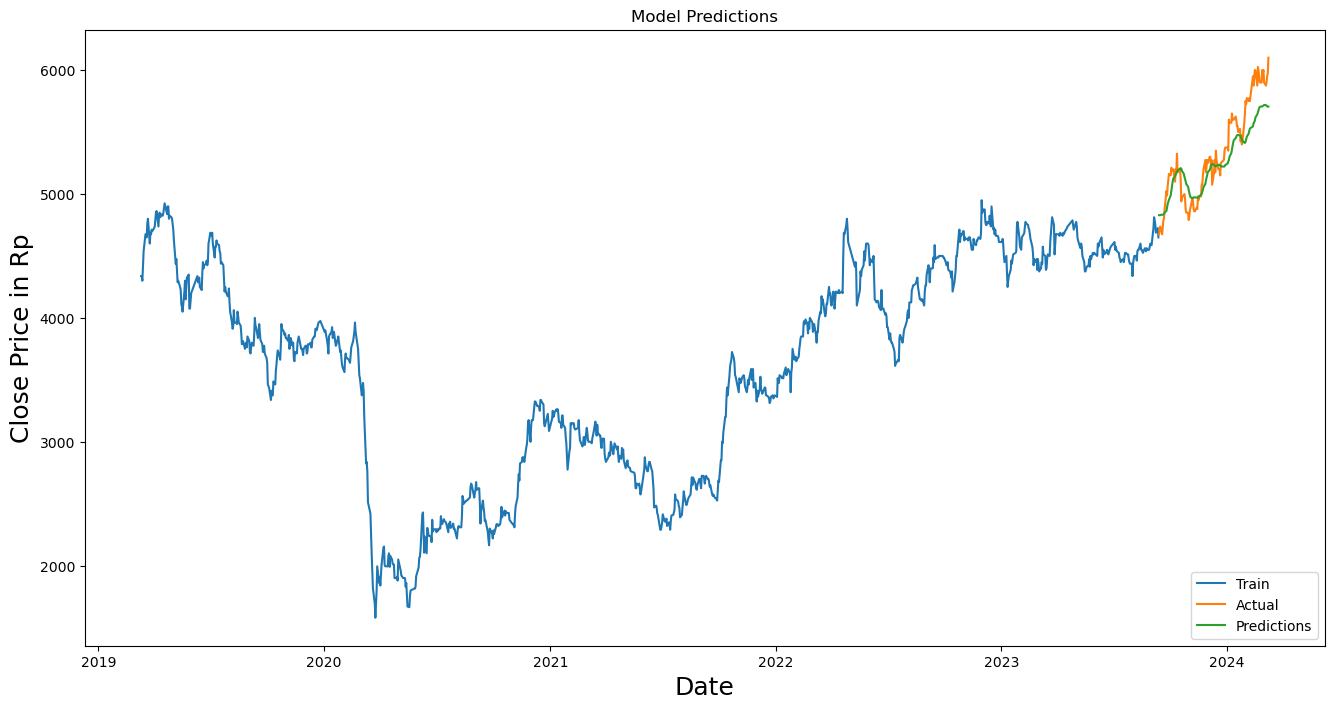

In [14]:
# Fetch testing and training data
train = data[:training_data_len]
valid = data[training_data_len:]

# Add 'Predictions'
valid['Predictions'] = predictions

# Plotting 
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)

# Plot training data
plt.plot(train['Close'], label='Train')

# Plot actual and prediction
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label='Predictions')

# Add legend
plt.legend(loc='lower right')
plt.show()

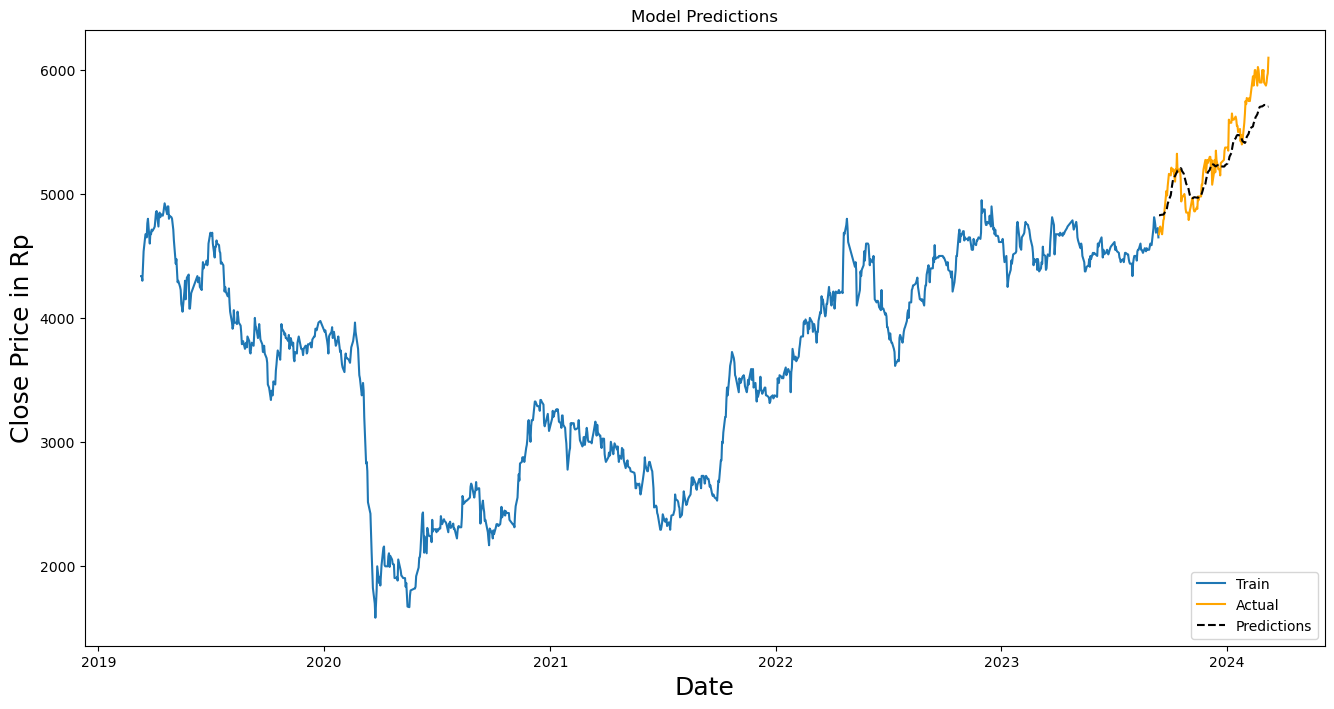

In [15]:
# Plotting 
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in Rp', fontsize=18)

# Plot training data
plt.plot(train['Close'], label='Train')

# Plot actual data
plt.plot(valid.index, valid['Close'], label='Actual', linestyle='-', color='orange')

# Plot prediction data
plt.plot(valid.index, valid['Predictions'], label='Predictions', linestyle='--', color='black')

# Add legend
plt.legend(loc='lower right')
plt.show()